# 3 Analysing distances networks 1-5km

Load in memory the temporal gasoline and diesel network with the fuel price of every station for every day.

This network will be mostly used as data structure to have a data fast access.

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
import raphtory as rp
import datetime
import os

In [2]:
# Load the temporal networks for gasoline and diesel prices in Lombardia
lombardia_gasoline = rp.Graph.load_from_file("../network/same_price/same_price_lombardia_stations_gasoline")
lombardia_diesel = rp.Graph.load_from_file("../network/same_price/same_price_lombardia_stations_diesel")

We are loading a series of distance-based networks into memory, representing connections between stations based on their physical proximity. These networks utilize a "binning" approach where a network of index $x$ (for $x \in \{1, \dots, 5\}$) connects two stations only if their distance $d$ falls within the interval:$$(x-1) < d \le x \text{ km}$$Example: In Distance Network 2, a connection exists between two stations if they are separated by more than 1 km but no more than 2 km.These networks were pre-calculated and generated in the NetworkCreation notebook and will serve as the foundation for our subsequent spatial analyses.

In [3]:
distances_network = {}

distances = [1, 2, 3, 4, 5]

# Load the distance networks for each specified distance in kilometers
for km in distances:
    distances_network[km] = nx.read_gexf(f"../network/distance/{km}_km_distance_network_Lombardia.gexf")

Nodes without daily pricing information were excluded from the distance network to align it with the diesel and gasoline price datasets.

In [4]:
no_price = []

# Identify nodes without price information in either gasoline or diesel networks
for node in distances_network[1].nodes:

    if lombardia_gasoline.node(node) is None or lombardia_diesel.node(node) is None:
        no_price.append(node)

# Remove nodes without price information from all distance networks
for node in no_price:
    for km in distances:
        distances_network[km].remove_node(node)

## 3.1 Matching

Given the distances network and the prices network  we are goin to add a **matching percentage** on every edge in the networks.

A **match** is defined as an instance where station **B** follows the price trajectory of its connected station, **A** (increasing, decreasing, or remaining stable), with an absolute price differential of less than **0.02** Euro cents. To quantify this relationship, the total number of matches is divided by the total number of observations and multiplied by 100. This resulting match percentage is then assigned as an attribute to the edge connecting the two stations.

The matching day are calculated on every distances network, from 1km to 5km and for every distance network with 6 different days of **lag** from 0 to 5.

From now on we will referring for the **matching percentage** only as **matching** in order to keep everything less complicated.

**Lag** equal to 0 means that we have a match if the two connceted stations change price at the same moment so day by day.

**Lag** more than 0 means that we have a match if, given the station **A** connected to **B**, the second one changes his price in the same way of A after **lag** days.

We have to change every network from undirected to directed, so from every node now we doesn't have one undirected edges but two directed edges.
This because for **lag** 0 the match from **A** to **B** is the same from **B** to **A** because the prices are changed for both stations simultaneously, this is not the case with **lag** bigger tha 0, a match from the station **A** to **B** is different than from **B** to **A**, this will help us understand if it's the station **A** that change following **B** or **B** that change following the price proposed by **A**.

So for **lag** equal to 0 we will have the same matching percentage from **A** to **B** and from **B** to **A**, but for **lag** bigger than 0 will very likely be different. 

In [5]:
# Function to calculate the matching percentage between price changes of neighboring nodes in the distance networks
def matching(distances_network, price_network, start_date, end_date, lag):

    actual_date = start_date

    # Iterate through each distance network
    for km in distances_network:

        # Ensure the network is directed
        # If the network is undirected, convert it to directed
        # This is necessary to ensure from where the match comes from
        if not distances_network[km].is_directed():
            distances_network[km] = distances_network[km].to_directed()
            

        for node in distances_network[km].nodes:

            fixed_node = price_network.node(node)

            # Iterate through each neighbor of the node
            for neighbor in distances_network[km].neighbors(node):

                neighbor_node = price_network.node(neighbor)

                matching_days = 0
                total_days = 0

                actual_date = start_date

                # Iterate through the dates in the specified range
                # This loop checks the price changes for the fixed node and its neighbor
                # and counts the days where both prices change in the same direction or remain unchanged
                # The lag is used to compare the price of the neighbor node with a lag of 'lag' days
                while( (actual_date + datetime.timedelta(days=lag+1)) <= end_date ):

                    # Skip if the node or neighbor node does not have data about the price for the current date
                    try:
                        # Calculate the price change for the fixed node is always the difference between the price of the next day and the current day
                        price_fixed = float(fixed_node.at(actual_date + datetime.timedelta(days=1)).properties["prezzo"])
                        change_fixed = price_fixed - float(fixed_node.at(actual_date).properties["prezzo"])

                        # Calculate the price change for the neighbor node with a lag of 'lag' days, is the difference between the price of the current day plus 'lag+1' 
                        # days and the price of the current day plus 'lag' days
                        #
                        # Example 
                        # lag = 2, Current day = 1
                        # change_fixed = price[2] - price[1]
                        # the change is between day 1 and 2, so with a lag of 2 we have to check price change after 2 days
                        # so between day 4 and 2
                        # change_neighbor = price[4] - price[3]
                        price_neighbor = float(neighbor_node.at(actual_date + datetime.timedelta(days=lag+1)).properties["prezzo"])
                        change_neighbor = price_neighbor - float(neighbor_node.at(actual_date + datetime.timedelta(days=lag)).properties["prezzo"])

                        total_days += 1
                        # If both changes are in the same direction or both are zero (no price change), count it as a matching day
                        if change_fixed * change_neighbor > 0 and abs(price_fixed - price_neighbor) <= 0.02:
                            matching_days += 1
                        elif change_fixed == 0 and change_neighbor == 0 and abs(price_fixed - price_neighbor) <= 0.02:
                            matching_days += 1
                    except:
                        pass

                    actual_date += datetime.timedelta(days=1)

                # Store the matching percentage in the distances_network
                name = f"{lag}_matching"
                if total_days == 0:
                    # If there are no days to compare, set the matching percentage to -1 to indicate that it is not applicable
                    distances_network[km][neighbor][node][name] = -1
                else:
                    distances_network[km][neighbor][node][name] = round((matching_days / total_days)*100,2)

    return distances_network      

In [6]:
# Remove edges with no matching percentage from the distances network
def removing_null_edges(distances_network):

    null_edges = set()

    # Iterate through each distance network
    for km in distances_network:
        
        for edge in distances_network[km].edges(data=True):
            if edge[2]["5_matching"] == -1:
                null_edges.add((km, edge[0], edge[1]))
                null_edges.add((km, edge[1], edge[0]))
    
    # Remove edges with no matching percentage
    for edge in null_edges:
        distances_network[edge[0]].remove_edge(edge[1], edge[2])
    
    return distances_network

In [7]:
price_matching_network_gasoline = distances_network.copy()
price_matching_network_diesel = distances_network.copy()

region_name = "Lombardia"

# Check if the GEXF files for the price matching networks already exist
# If they do, load them; otherwise, calculate the networks
# and save them to GEXF files
# This avoids recalculating the networks if they have already been computed
# and stored in the specified directory
# The GEXF files are named according to the distance in kilometers and the region name
# For example, for 1 km distance and Lombardia region, the file name is:
# "1_km_price_matching_network_Lombardia_gasoline.gexf"
# and "1_km_price_matching_network_Lombardia_diesel.gexf"
if(os.path.exists(f"../network/price_matching/1_km_price_matching_network_{region_name}_gasoline.gexf")):

    for km in distances:
        price_matching_network_gasoline[km] = nx.read_gexf(f"../network/price_matching/{km}_km_price_matching_network_{region_name}_gasoline.gexf")
        price_matching_network_diesel[km] = nx.read_gexf(f"../network/price_matching/{km}_km_price_matching_network_{region_name}_diesel.gexf")

else:
    
    start_date = datetime.datetime(2025, 4, 1)
    end_date = datetime.datetime(2025, 6, 30)

    #  Calculate the price matching networks for gasoline and diesel with lags from 0 to 5 days
    for lag in range (0,6):
        price_matching_network_gasoline = matching(price_matching_network_gasoline, lombardia_gasoline, start_date, end_date,lag)
        price_matching_network_diesel = matching(price_matching_network_diesel, lombardia_diesel, start_date, end_date,lag)
    
    # Remove edges with no matching percentage
    price_matching_network_gasoline = removing_null_edges(price_matching_network_gasoline)
    price_matching_network_diesel = removing_null_edges(price_matching_network_diesel)

    # Write the resulting networks to GEXF files with unique IDs for edges
    for km in distances:

        id_counter = 0
        for edge in price_matching_network_gasoline[km].edges(data=True):
            price_matching_network_gasoline[km][edge[0]][edge[1]]["id"] = id_counter
            id_counter += 1
        
        id_counter = 0
        for edge in price_matching_network_diesel[km].edges(data=True):
            price_matching_network_diesel[km][edge[0]][edge[1]]["id"] = id_counter
            id_counter += 1
            
        file_name = f"../network/price_matching/{km}_km_price_matching_network_{region_name}_gasoline.gexf"
        nx.write_gexf(price_matching_network_gasoline[km], file_name)

        file_name = f"../network/price_matching/{km}_km_price_matching_network_{region_name}_diesel.gexf"
        nx.write_gexf(price_matching_network_diesel[km], file_name)

## 3.2 High matching edges and Influencers

After calculating the matching between every stations we check and extract the **influencers** and the **high matching edges** inside the networks.

A **high matching edge** is an edge that have (for a fixed km and lag) a matching higher than 50.

An **influencer** is a node that has (for a fixed km and lag) at least 50% of his in coming edge (nodes that copy it) with a **matching higher than 50**.

Both the **influencers** and the **high matching edge** are calculated for every km and every days of lag.

In [8]:
# Function to identify high matching nodes and influencers in the price matching network
def high_matching_and_influencers(price_matching_network):
    influencers = {}
    high_matching_edges = {}

    # Iterate through each distance network in the price matching network
    for km in price_matching_network:

        influencers[km] = {}
        high_matching_edges[km] = {}

        # Iterate through each node in the distance network
        for node in price_matching_network[km].nodes():
            G = price_matching_network[km]

            # Initialize the influencers and high matching edges for each lag
            for lag in range(0, 6):

                if lag not in influencers[km]:
                    influencers[km][lag] = set()
                    high_matching_edges[km][lag] = set()

                counter = 0
                in_edges = G.in_edges(node, data=True)
                for edge in in_edges:

                    # If the matching percentage is greater than 50%, count it as a high matching edge
                    if edge[2][f"{lag}_matching"] > 50:
                        counter += 1

                        # Add the edge to the high matching edges set
                        # Ensure the edge is stored in a consistent order (lower ID first)
                        # This is to avoid duplicates like (1,2) and (2,1)
                        high_matching_edges[km][lag].add((edge[1],edge[0]))
                
                # If there are valid edges and the percentage of high matching edges is greater than or equal to 50%, add the node as an influencer
                if len(in_edges) > 0 and counter / len(in_edges) >= 0.5:
                    influencers[km][lag].add(node)

    # Return the influencers and high matching edges for each distance network
    return influencers, high_matching_edges

influencers_gasoline, high_matching_gasoline = high_matching_and_influencers(price_matching_network_gasoline)
influencers_diesel, high_matching_diesel = high_matching_and_influencers(price_matching_network_diesel)

Printing the number of nodes and edges for every distance network.

In [9]:
for l in price_matching_network_gasoline:
    print(f"Network for {l} km distance loaded with {len(price_matching_network_gasoline[l].nodes())} nodes and {len(price_matching_network_gasoline[l].edges())} edges.")

Network for 1 km distance loaded with 2661 nodes and 2870 edges.
Network for 2 km distance loaded with 2661 nodes and 7740 edges.
Network for 3 km distance loaded with 2661 nodes and 12262 edges.
Network for 4 km distance loaded with 2661 nodes and 17130 edges.
Network for 5 km distance loaded with 2661 nodes and 20638 edges.


In [10]:
for l in price_matching_network_gasoline:
    print(f"Network for {l} km distance loaded with {len(price_matching_network_diesel[l].nodes())} nodes and {len(price_matching_network_diesel[l].edges())} edges.")

Network for 1 km distance loaded with 2661 nodes and 2870 edges.
Network for 2 km distance loaded with 2661 nodes and 7740 edges.
Network for 3 km distance loaded with 2661 nodes and 12262 edges.
Network for 4 km distance loaded with 2661 nodes and 17130 edges.
Network for 5 km distance loaded with 2661 nodes and 20638 edges.


Printing the percentage of **influencer** over the total of nodes, and the percentage of **high matching edges** over the total of edges for every km and day of lag.

After giving a quick view of the data we can see that increasing in **km** and **lag** reduce the percentage of influencers and high matching edges present in the networks, this means that by more km are the stations divided less the possibility that they have an high influence over each other, and the more days pass after a change in price from a station less the possibility that another stations will adapt to the new price.

If we look closer in this negative trend we can see, that the decreasing difference in the high matching edges from lag 0 to lag 1 is negligible always less than 1%, same for the number of influencer that in some case it will also increase.

We also have to keep in mind that as concern the **lag 0** every high matching nodes goes in two directions because the change in price it is simultaneous, **A** change with **B** and **B** with **A**, if we want to be precise the number of high matching edge for **lag 0** should be divided by two.
We can also have between two different stations mutual edges with lag greater than 0 but in this case the information obtained is different, it tells us that the two stations adapt to each other continuously after a certain number of days.

In [11]:
import plotly.express as px

# Function to visualize the percentage of influencers and high matching edges in the price matching network
def print_hign_matching_and_influencers(price_matching_network, influencers, high_matching_edges,fuel_type):
    
    data_influencers,data_high_matching  = [], []

    for km in influencers:

        total_edges = len(price_matching_network[km].edges())
        total_nodes = len(price_matching_network[km].nodes())

        row_influencers,row_high_matching = [], []

        for lag in influencers[km]:

            row_influencers.append(round(len(influencers[km][lag]) / total_nodes*100,2))
            row_high_matching.append(round(len(high_matching_edges[km][lag]) / total_edges*100,2))

        data_influencers.append(row_influencers)
        data_high_matching.append(row_high_matching)

    fig_influencers = px.imshow(data_influencers, text_auto=True, 
                    aspect="auto", 
                    title=f"<b>Influencers</b> in <b>{fuel_type}</b> price matching network", 
                    labels=dict(x="Days of Lag", y="Distance (km)", color="%"),
                    y=["1", "2", "3", "4", "5"],color_continuous_scale='turbid')
    fig_influencers.update_xaxes(side="top")
    
    fig_high_matching = px.imshow(data_high_matching, text_auto=True, 
                    aspect="auto", 
                    title=f"<b>High matching edges</b> in <b>{fuel_type}</b> price matching network", 
                    labels=dict(x="Days of Lag", y="Distance (km)", color="%"),
                    y=["1", "2", "3", "4", "5"],color_continuous_scale='turbid')
    fig_high_matching.update_xaxes(side="top")

    fig_influencers.show()
    fig_high_matching.show()

print_hign_matching_and_influencers(price_matching_network_gasoline,influencers_gasoline,high_matching_gasoline,"Gasoline")

In [12]:
print_hign_matching_and_influencers(price_matching_network_diesel,influencers_diesel,high_matching_diesel,"Diesel")

# 4 Analysis on 3km distance networks

After the quick observations made previously I've decided to merge for both fuels the 1,2 and 3km network and make further analysis.

In [13]:
from collections import Counter
import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as mtick

In [14]:
# Create combined price matching networks for 3 km distance by merging the networks for 1 km, 2 km, and 3 km distances
price_matching_network_gasoline_3km = price_matching_network_gasoline[1].copy()
price_matching_network_gasoline_3km.update(price_matching_network_gasoline[2])
price_matching_network_gasoline_3km.update(price_matching_network_gasoline[3])
    
price_matching_network_diesel_3km = price_matching_network_diesel[1].copy()
price_matching_network_diesel_3km.update(price_matching_network_diesel[2])
price_matching_network_diesel_3km.update(price_matching_network_diesel[3])

# Assign unique IDs to edges in the 3 km price matching networks for gasoline and diesel
counter = 1
for edge in price_matching_network_gasoline_3km.edges(data=True):
    price_matching_network_gasoline_3km[edge[0]][edge[1]]["id"] = counter
    price_matching_network_diesel_3km[edge[0]][edge[1]]["id"] = counter
    counter += 1

## 4.1 Influencers inside the 3km netowrks

Code for find influencer in the new network, the criterion for establishing and influencer isn't changed

In [15]:
# Function to identify influencers in the 3 km price matching network
def influencers_3km(price_matching_network):
    
    # Iterate through each node in the price matching network
    for node in price_matching_network.nodes:
        
        # Get all incoming edges for the node
        in_edges = price_matching_network.in_edges(node, data=True)

        # Iterate through each lag from 0 to 5 days
        for lag in range(0,6):
            high_matching = 0
            
            # Count the number of incoming edges with matching percentage greater than 50%
            for edge in in_edges:
                if edge[2][f"{lag}_matching"] > 50:
                    high_matching += 1

            # Determine if the node is an influencer based on the percentage of high matching edges
            if len(in_edges) > 0 and high_matching / len(in_edges) >= 0.5:
                price_matching_network.nodes[node][f"{lag}_influencer"] = True
            else:
                price_matching_network.nodes[node][f"{lag}_influencer"] = False
    
influencers_3km(price_matching_network_gasoline_3km)
influencers_3km(price_matching_network_diesel_3km)

In [16]:
# Function to extract the list of influencers based on the specified lag
def extract_influencers(price_matching_network, days_of_lag):
    
    attr_name = f"{days_of_lag}_influencer"

    # Extract the list of influencers based on the specified lag
    static_influencers_list = [
        n for n, attr in price_matching_network.nodes(data=True) 
        if attr.get(attr_name) == True
    ]
    
    return static_influencers_list

### 4.1.1 Influencers and degree

Here we are going to compare the degree distribution of the **1_influencers** (influencers after 1 day of lag) and the other node that are not influecers.

From now one we opted for a **lag 1** approach to prioritize direct correlation. A shorter interval minimizes the influence of confounding variables that might arise over a five-day period, ensuring that observed price mirroring is a result of competition. Additionally, this approach take less time.

In [17]:
# Function to compare the degree distribution of influencers and non-influencers
def degree_normal_influencer(price_matching_network, static_influencers_list):
    degrees = dict(price_matching_network.degree())

    influencer_degrees = [degrees[n] for n in static_influencers_list if n in degrees]
    non_influencer_degrees = [degrees[n] for n in price_matching_network_gasoline_3km.nodes if n not in static_influencers_list]

    plt.figure(figsize=(10, 6))
    plt.hist(influencer_degrees, bins=30, alpha=0.5, label='Influencers', density=True, color='#8f6139')
    plt.hist(non_influencer_degrees, bins=30, alpha=0.5, label='Non Influencers', density=True, color='#302721')
    plt.title(f'Degree distribution')
    plt.xlabel('Degree (Number of neighbors)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    print(f"Average Degree of Influencers: {sum(influencer_degrees)/len(influencer_degrees):.2f}")
    print(f"Average Degree of Non Influencers: {sum(non_influencer_degrees)/len(non_influencer_degrees):.2f}")

From what we can see in the graphics below for both gasoline and diesel the **1_influencer** have less average degree compared to the non influencer, this mean that having a lot of neighbours and be very well integrated in the network doesn't mean that you are automatically an influencer.

In traditional network theory, Degree Centrality is often synonymous with Power. However, our findings suggest the opposite: high connectivity appears to dilute a station's influence. Instead of a hub effect, we observe that relative isolation or having fewer neighbors creates a clearer, more imitable price signal, making these stations more effective points of reference.

High degree nodes are typically concentrated in dense urban centers like Milan. However, in these environments, price leadership is diluted; it is statistically improbable for a station to influence a significant majority of its 50 neighbors simultaneously. In contrast, stations in less saturated areas with fewer neighbors (like four) exert a more potent influence, as their competitors can monitor and respond to their pricing signals directly without the interference of a crowded market.

These results suggest that the market is not driven by major "Conductors" commanding vast areas, but rather by numerous local team Leaders. The Lombardy market appears fragmented into many small islands of local influence clusters, rather than functioning as a single, centralized empire.

---GASOLINE---


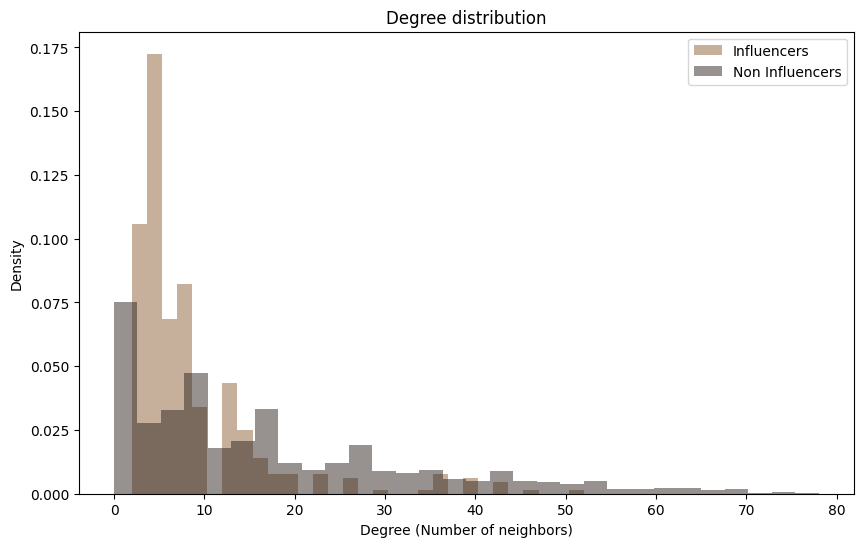

Average Degree of Influencers: 8.35
Average Degree of Non Influencers: 16.82


In [18]:
print("---GASOLINE---")
degree_normal_influencer(price_matching_network_gasoline_3km, extract_influencers(price_matching_network_gasoline_3km, 1))

---DIESEL---


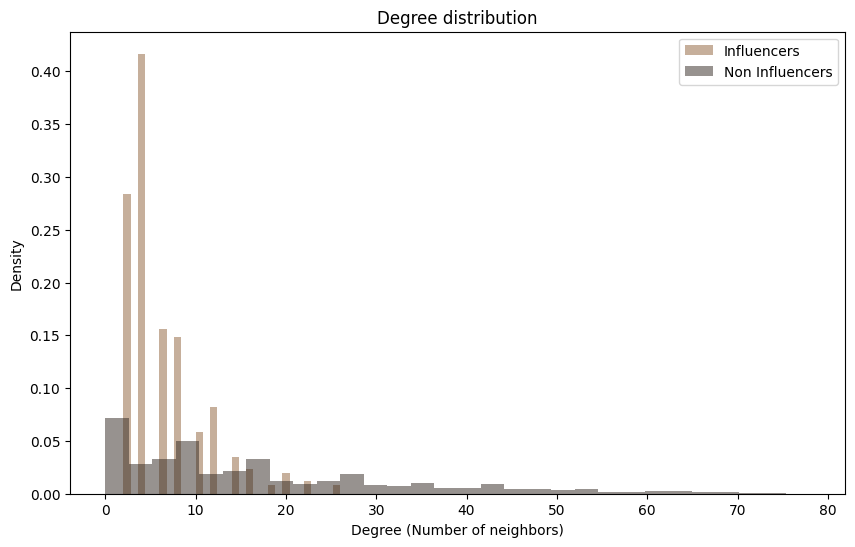

Average Degree of Influencers: 6.22
Average Degree of Non Influencers: 16.88


In [19]:
print("---DIESEL---")
degree_normal_influencer(price_matching_network_diesel_3km, extract_influencers(price_matching_network_diesel_3km, 1))

### 4.1.2 Influencers and brand

The Italian fuel market is dominated by major national and international brands such as Eni/Agip, Q8, IP, Esso, and Tamoil. 

However, a significant portion of the market consists of independent retailers, locally known as "Pompe Bianche" (White Pumps). These range from supermarket chains like Coop to small family owned stations. Because the raw dataset inconsistently labels these independents, often categorizing specific brands like **Keropetrol** separately rather than under the unified "Pompe bianche" tag, we applied a secondary classification. To ensure consistency, we defined any brand with a market share of less than 5% as a White Pump for the purposes of this analysis.

In [20]:
all_brand = Counter()

# Count the occurrences of each brand in the price matching network for gasoline
for node in price_matching_network_gasoline_3km.nodes():
    actual_brand = lombardia_gasoline.node(node).properties["Bandiera"]
    all_brand[actual_brand] += 1

white_pumps = {}

# Calculate the percentage of each brand and identify those with less than 5% representation as "white pumps"
for brand, percentage in all_brand.items():
    actual_percentage = round(percentage/sum(all_brand.values())*100,2)
    
    if actual_percentage < 5.0:
        white_pumps[brand] = actual_percentage

In [21]:
# Function for analyzing the percentage of stations that are influencers for each brand in the price matching network
# Accumulated can be set to True to group all the brands with less than 5% representation as "Pompe bianche" 
# or False to keep them all separated, so we can see little brand like Keropetrol
def brand_influencer_analysis(price_matching_network, price_network, accumulated=True):
    static_brand_counts = Counter()
    brand_counts = Counter() 

    # Depending on the value of accumulated, either group all brands with less 
    # than 5% representation as "Pompe Bianche" or keep them separated
    if accumulated:
        accumulated = "collapsed white pumps"
        for brand in all_brand:

            if brand in white_pumps:
                    brand_counts["Pompe Bianche"] += all_brand[brand]
            else:
                    brand_counts[brand] += all_brand[brand]
    else:
        accumulated = "all white pumps"
        brand_counts = all_brand

    # Count influencers per brand
    for n in extract_influencers(price_matching_network, 1):
        brand = price_network.node(n).properties["Bandiera"]
        static_brand_counts[brand] += 1

    # Calculate % (How many stations of that brand are influencers?)
    static_efficiency = {}
    for brand, count in static_brand_counts.items():
        # Only consider brands with more than 1 station to avoid 
        # skewed percentages for brands with only one station
        if brand_counts[brand] > 1:
            static_efficiency[brand] = count / brand_counts[brand]

    # Plot
    sorted_static = sorted(static_efficiency.items(), key=lambda x: x[1], reverse=True)[:10]
    brands_s = [x[0] for x in sorted_static]
    values_s = [x[1] for x in sorted_static]

    plt.figure(figsize=(12, 6))
    
    ax = plt.gca() # Prendi l'asse corrente
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.bar(brands_s, values_s, color='#8f6139', alpha=0.7)
    plt.title(f'% of stations that are influencers (Lag {1}) - {accumulated} - Diesel')
    plt.xticks(rotation=45, ha='right')
    plt.show()

Although the first chart indicates that, for both fuels, White Pumps (independent retailers) collectively show one of the lowest percentages of influencers compared to major brands, this evidence is attributable to the high internal heterogeneity of the category. The process of aggregation combines extremely diverse entities, thereby diluting the impact of those specific operators acting as true 'price disruptors.'

This ambiguity is resolved in the second chart, where the disaggregated analysis reveals the true power of independent brands. In the gasoline market, for instance, the case of LP Carburanti is emblematic: 50% of its stations are classified as influencers. From a predictive standpoint, this implies that the opening of a new point of sale under this brand would have a 50% probability of influencing its surrounding micro-network.

However, consistent with the discussion in @sec-inf-grado, this capacity for influence remains constrained by the network topology: leadership is successfully manifested only where the number of neighbors is not excessively high. In contexts of intense urban hyper-competition, even an aggressive operator finds its price signal saturated by the 'noise' of other competitors. In summary, while White Pumps do not stand out in the aggregate data—as many of them operate in high-competition areas—the granular analysis demonstrates that the ability of individual independent brands to dictate prices is superior to that of any Major oil company.

---GASOLINE---


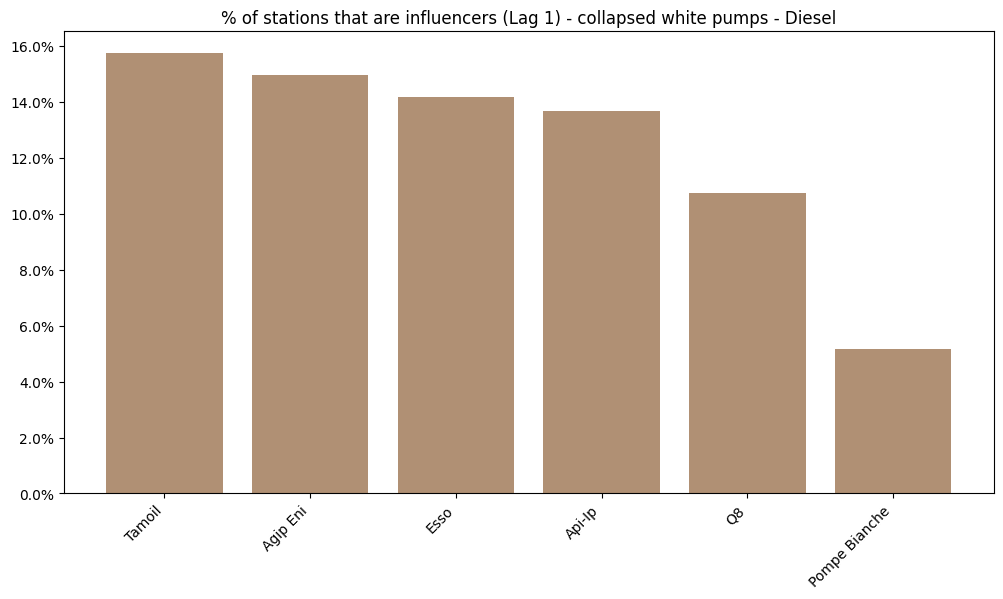

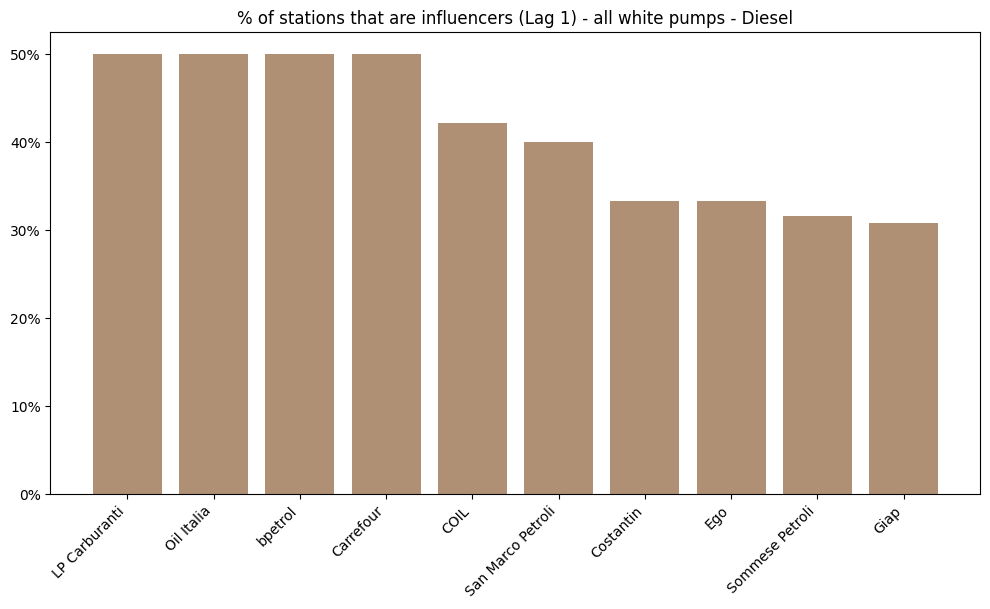

In [22]:
print("---GASOLINE---")
brand_influencer_analysis(price_matching_network_gasoline_3km, lombardia_gasoline, True)
brand_influencer_analysis(price_matching_network_gasoline_3km, lombardia_gasoline, False)

---DIESEL---


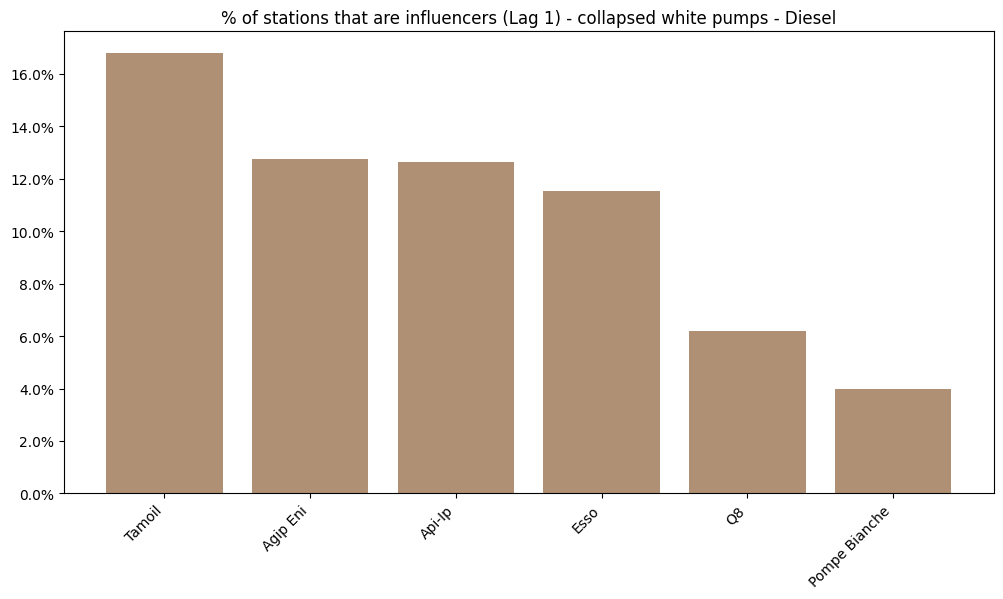

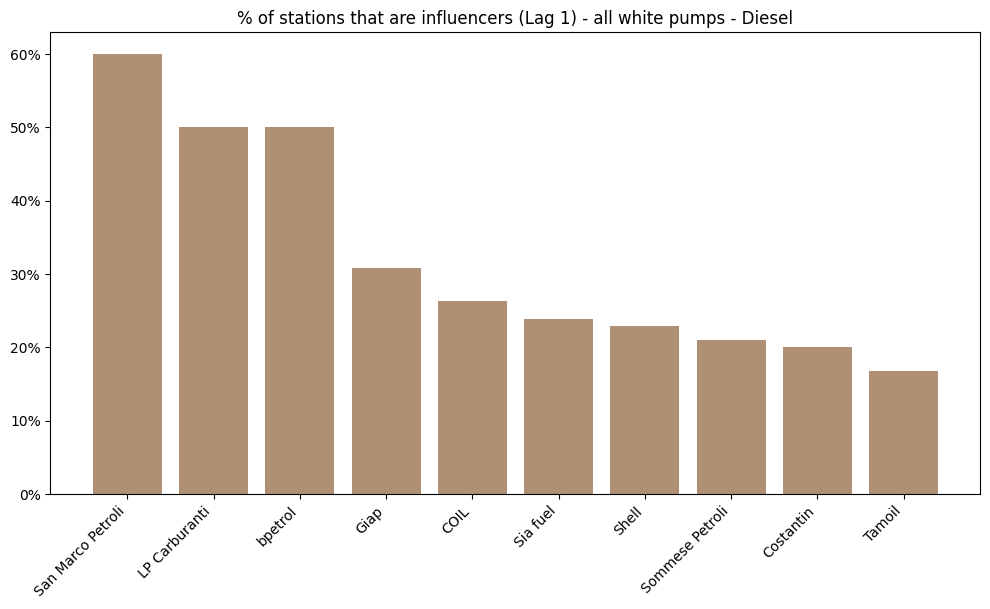

In [23]:
print("---DIESEL---")
brand_influencer_analysis(price_matching_network_diesel_3km, lombardia_diesel, True)
brand_influencer_analysis(price_matching_network_diesel_3km, lombardia_diesel, False)

## 4.2 Cascades inside the 3km networks

While the previous analysis focused on immediate spatial influence within a local neighborhood, we now expand our scope to examine temporal propagation. This section identifies macro influencers nodes, that trigger cascades of influence across the network over multiple days, effectively acting as the catalysts for broader market shifts.

We define a price cascade as a time ordered sequence of matching events. For example, if station $A$ adjusts its price at time $t$, station $B$ responds at $t+1$, and station $C$ follows $B$ at $t+2$, we identify a directed propagation path: $A \to B \to C$. Notably, our model allows for temporal cycles (e.g., $A \to B \to C \to A$ or $A \to B \to A$). Because we treat each directed edge as a time-stamped event, a link from $A$ to $B$ at $t$ is treated as a distinct analytical unit from the same spatial link at $t+1$.

Rememeber that our criteria for a price match require two conditions: first, station $B$ must follow the directional price change of station $A$ with a one day lag (Lag 1); second, the price difference between the two stations must not exceed 0.02 Euro cents.

In [24]:
start_date = datetime.datetime(2025, 4, 1)
end_date = datetime.datetime(2025, 6, 30)

# Function to find cascades of price changes
def cascades_finder(price_matching_network, price_network):
    
    # Initialize a counter and a path dictionary to store the cascades
    counter = 0
    cascade = {}
    
    # Iterate through each node in the price matching network
    for node in price_matching_network.nodes:
        
        counter += 1
        if counter % 500 == 0:
            print(f"Processing node {counter} / {len(price_matching_network.nodes)}")
        
        # Initialize the actual date to the start date
        actual_date = start_date
        
        # Iterate through the dates in the specified range
        # This loop explores the cascades of price changes starting from each node on each date
        while actual_date + datetime.timedelta(days=1) <= end_date:
            
            # Set to track expanded (node, date) pairs to handle reconvergences
            expanded_states = set()
            
            # Initialize the path for the current node and date
            cascade.setdefault(node, {})
            current_path_list = list()
            
            # The root node is always expanded
            root_date = actual_date
            expanded_states.add((node, root_date))
            
            # Add the root node to the current path list
            current_path_list.append({
                "src": node, 
                "dst": node, 
                "date": root_date, 
                "parent_index": -1,
                "expand": True # Useful flag to indicate if we should expand this node
            })
            
            cascade[node][actual_date] = current_path_list
            
            # Begin exploring the cascade from the current path list
            current_index = 0
            
            # Loop through the current path list to explore the cascade
            while current_index < len(current_path_list):
                
                step = current_path_list[current_index]
                
                # If 'expand' is False, this node is a duplicate
                # We recorded it for statistics, but we do not search for its children to avoid duplicates and loops
                if step["expand"] is False:
                    current_index += 1
                    continue
                
                # Skip if there is not enough data to check the price change for the next two days
                if step["date"] + datetime.timedelta(days=2) > end_date:
                    current_index += 1
                    continue
                
                # Try to access the fixed node in the price network
                try:
                    fixed_node = price_network.node(step["dst"])
                    
                    # Price calculation for the fixed node
                    price_fixed_t1 = float(fixed_node.at(step["date"] + datetime.timedelta(days=1)).properties["prezzo"])
                    price_fixed_t0 = float(fixed_node.at(step["date"]).properties["prezzo"])
                    
                    change_fixed = price_fixed_t1 - price_fixed_t0
                    
                    for neighbor in price_matching_network.neighbors(step["dst"]):
                        
                        try:
                            neighbor_node = price_network.node(neighbor)
                            
                            # Price calculation for the neighbor node
                            price_neighbor_t2 = float(neighbor_node.at(step["date"] + datetime.timedelta(days=2)).properties["prezzo"])
                            price_neighbor_t1 = float(neighbor_node.at(step["date"] + datetime.timedelta(days=1)).properties["prezzo"])
                            
                            change_neighbor = price_neighbor_t2 - price_neighbor_t1
                            
                            # Check if both nodes have price changes in the same direction and prices are within 0.02
                            if (change_fixed * change_neighbor > 0) and (abs(price_fixed_t1 - price_neighbor_t2) <= 0.02):
                                
                                next_date = step["date"] + datetime.timedelta(days=1)
                                
                                should_expand = False
                                
                                # If we have NOT yet processed this neighbor on THIS date...
                                if (neighbor, next_date) not in expanded_states:
                                    should_expand = True # ...then we will search for its children
                                    expanded_states.add((neighbor, next_date))
                                else:
                                    should_expand = False # ...otherwise we add it only as a "leaf" (additional link)
                                
                                new_step = {
                                    "src": step["dst"], 
                                    "dst": neighbor, 
                                    "date": next_date, 
                                    "parent_index": current_index,
                                    "expand": should_expand
                                }
                                
                                # Add the new step to the current path list
                                current_path_list.append(new_step)
                                
                        except (KeyError, ValueError, AttributeError):
                            pass
                
                except (KeyError, ValueError, AttributeError):
                    pass
                
                current_index += 1
                
            actual_date += datetime.timedelta(days=1)
    
    return cascade

In [25]:
cascades_gasoline = cascades_finder(price_matching_network_gasoline_3km, lombardia_gasoline)
cascades_diesel = cascades_finder(price_matching_network_diesel_3km, lombardia_diesel)

Processing node 500 / 2661
Processing node 1000 / 2661
Processing node 1500 / 2661
Processing node 2000 / 2661
Processing node 2500 / 2661
Processing node 500 / 2661
Processing node 1000 / 2661
Processing node 1500 / 2661
Processing node 2000 / 2661
Processing node 2500 / 2661


We now extend our analysis to identify high order cascades sequences with a depth exceeding two steps (e.g., $A \to B \to C \to D$). For each node, we calculate the frequency of the multi day cascades it initiates. 

In [26]:
# Function to filter true initiators of cascades based on the depth of the cascade and the chronological order of events
def filter_true_initiators(cascades):
    
    # Flatten the cascade dictionary into a list for chronological sorting
    # Structure of the list: (Start_Date, Root_Node, Entire_Event_List)
    all_potential_cascades = []
    
    # For each node and each date, check if the cascade is deep enough
    for node in cascades:
        for date in cascades[node]:
            cascade_list = cascades[node][date]
            
            # Count unique "parents" to determine if the cascade is deep
            unique_parents = {link["parent_index"] for link in cascade_list}
            
            # If the cascade is deep enough (> 2 unique parents involved)
            # Like at least A -> B -> C -> D 
            if len(unique_parents) > 2:
                all_potential_cascades.append((date, node, cascade_list))

    # We sort by date. If A influences B, A starts first
    # This ensures we analyze the "father" before the "child".
    all_potential_cascades.sort(key=lambda x: x[0])

    # Useful to track true initiators
    true_initiators = Counter()
    # Keeps track of: (node, date_when_influenced)
    influenced_registry = set() 

    for start_date, node, cascade_list in all_potential_cascades:
        
        # If this node on this date has already been marked as "influenced" by someone else
        # then it is NOT a true initiator, but only an intermediate step. We skip it.
        if (node, start_date) in influenced_registry:
            continue
            
        # OTHERWISE: It is a true initiator!
        true_initiators[node] += 1
        
        # Now we add all downstream nodes: they cannot claim to be initiators
        # step['dst'] is the influenced node, step['date'] is when it gets influenced
        # We add it to the registry so if we encounter it later as 'root', we discard it
        for step in cascade_list:
            influenced_registry.add((step['dst'], step['date']))
    
    return true_initiators

In [27]:
true_initiators_gasoline = filter_true_initiators(cascades_gasoline)
true_initiators_diesel = filter_true_initiators(cascades_diesel)

### 4.2.1 Cascades and degree

Following our initial assessment of local influencers (1_influencers), we now examine the correlation between node degree and cascade initiation. Our objective is to determine if high connectivity serves as a predictor for deep price propagation. Specifically, we investigate whether stations with the highest number of neighbors are also responsible for triggering long temporal cascades.

In [28]:
# Function to analyze the correlation between the degree of nodes and tnumber of cascades initiated by those nodes
def correlation_initiators_degree(true_initiators, price_matching_network):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import pearsonr, spearmanr

    # Extract degrees
    static_degrees = dict(price_matching_network.degree())

    # Taking only nodes that have initiated cascades
    x_degree = []
    y_cascades = []
    labels = []

    for node_id, cascade_count in true_initiators.items():
        if node_id in static_degrees:
            x_degree.append(static_degrees[node_id])
            y_cascades.append(cascade_count)
            labels.append(node_id)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_degree, y_cascades, alpha=0.7, c="#8f6139")

    # Linear fit to see the trend
    m, q = np.polyfit(x_degree, y_cascades, 1)
    plt.plot(
        x_degree,
        m * np.array(x_degree) + q,
        color="red",
        linestyle="--",
        label=f"Trend (slope={m:.2f})",
    )

    plt.xlabel("Degree (Number of neighbors within 3km radius)")
    plt.ylabel("Influence Power (Number of cascades initiated)")
    plt.title("Number of cascades started vs Degree of the station")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate correlation
    # Pearson (Linearity)
    corr_pearson, p_value_pearson = pearsonr(x_degree, y_cascades)

    print(f"--- Statistical Results ---")
    print(f"1. Pearson Correlation (Linearity): r = {corr_pearson:.3f}")
    print(f"   P-value: {p_value_pearson:.5e}") 


    corr_spearman, p_value_spearman = spearmanr(x_degree, y_cascades)

    print(f"\n2. Spearman Correlation : rho = {corr_spearman:.3f}")
    print(f"   P-value: {p_value_spearman:.5e}")

As we can see for both graphics the trend line slope is positive but weak (slope=0.03 for Gasoline, 0.02 for Diesel), this means that while having more neighbors helps a bit from a statistical standpoint, it is by no means a guarantee of success.

**Pearson** (r ≈ 0.21 - 0.28): Positive but low linear correlation.

**Spearman** (rho ≈ 0.30 - 0.34): Slightly higher. This indicates that the relationship is monotonic (more neighbors = generally more influence), but not linear.

As seen before having 80 neighbors (being in the heart of Milan) theoretically gives you more opportunities to influence someone.
However, we see many points with an extremely high Degree (70-80) but very low Influence Power (1 or 2 cascades). They are "silent giants": surrounded by everyone, but listened to by no one. Conversely, we see points with a medium-low Degree (20-30) that boast very high Influence Power (10-11 cascades). These are the "small leaders": they have few neighbors, but those few always follow their lead.

In dense areas (high Degree), there is too much "noise." If you have 50 competitors, it’s unlikely that everyone is looking at you. Everyone is looking at someone else. In less dense areas, relationships are more direct and exclusive. If you are the only budget-friendly gas station in the valley, everyone is watching you.

Degree (spatial centrality) is a necessary but not sufficient predictor of influence. To be a price leader, simply being visible to many (degree) is not enough; you must have an aggressive pricing strategy (being an independent station "Pompa Bianca" or a market mover) that forces others to react.

In short: geographic location matters, but commercial strategy matters more.

---GASOLINE---


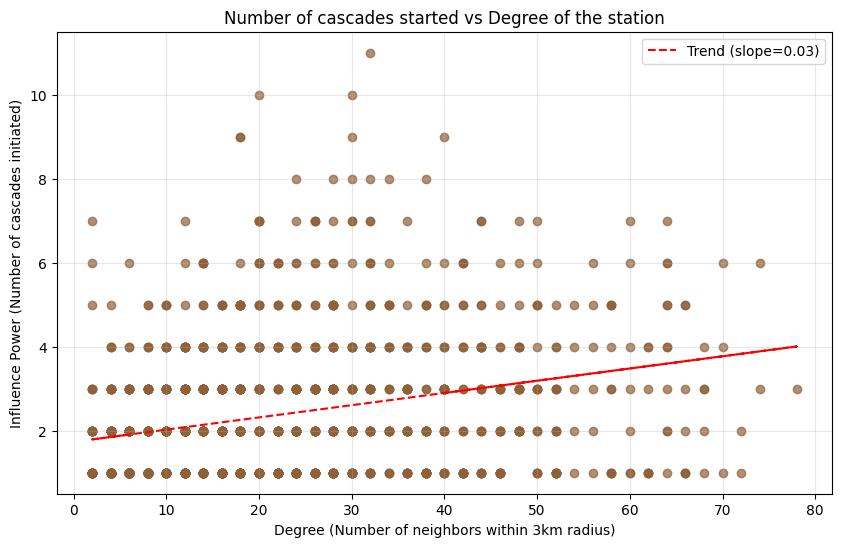

--- Statistical Results ---
1. Pearson Correlation (Linearity): r = 0.285
   P-value: 6.03854e-28

2. Spearman Correlation : rho = 0.339
   P-value: 2.32227e-39


In [29]:
print("---GASOLINE---")
correlation_initiators_degree(true_initiators_gasoline, price_matching_network_gasoline_3km)

---DIESEL---


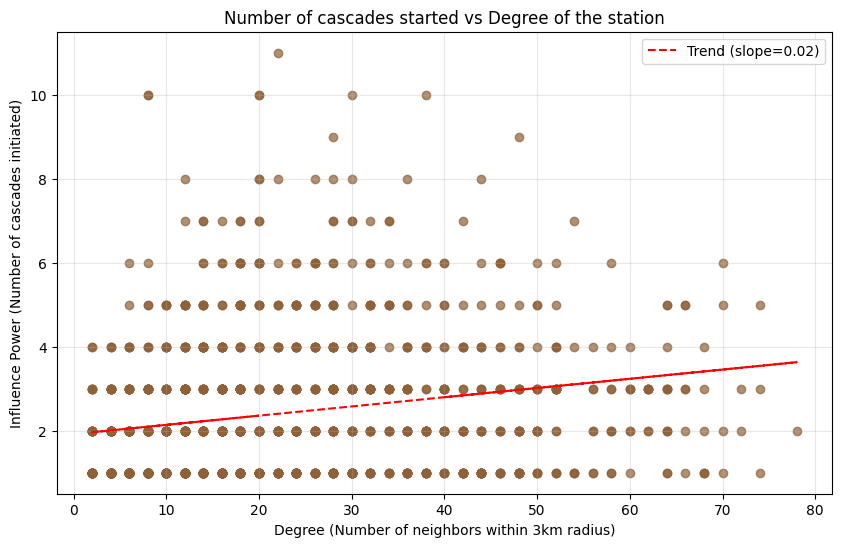

--- Statistical Results ---
1. Pearson Correlation (Linearity): r = 0.213
   P-value: 3.86949e-16

2. Spearman Correlation : rho = 0.296
   P-value: 3.14034e-30


In [30]:
print("---DIESEL---")
correlation_initiators_degree(true_initiators_diesel, price_matching_network_diesel_3km)

### 4.2.2 Cascades and brand

As we did for 1_influencers, let's now analyze which brands initiate the most cascades, with and without regrouping the little brand under the "Pompe Bianche".

In [31]:
# Function to analyze brand influence based on true initiators
def brand_influence_analysis(true_initiators, price_network, accumulated=True):

    brand_influence = Counter()
    brand_counts = Counter()

    # Calculate the number of stations per brand
    # if accumulated is True, group minor brands into "Pompe Bianche"
    if accumulated:
        acc = "collapsed white pumps"
        for brand in all_brand:

            if brand in white_pumps:
                brand_counts["Pompe Bianche"] += all_brand[brand]
            else:
                brand_counts[brand] += all_brand[brand]
    else:
        acc= "all white pumps"
        brand_counts = all_brand

    # Calculate total cascades initiated per brand
    for node_id, cascade_count in true_initiators.items():
        try:
            node_props = price_network.node(node_id)
            brand = node_props.properties["Bandiera"]

            if accumulated and brand in white_pumps:
                brand = "Pompe Bianche"

            brand_influence[brand] += cascade_count
        except:
            pass

    # Average cascades per station for each brand
    brand_efficiency = {}
    for brand, total_cascades in brand_influence.items():
        brand_efficiency[brand] = total_cascades / brand_counts[brand]

    # Top 10 brands by efficiency
    sorted_brands = sorted(brand_efficiency.items(), key=lambda x: x[1], reverse=True)[:10]

    # Prepare data for plotting
    brands = [x[0] for x in sorted_brands]
    values = [x[1] for x in sorted_brands]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(brands, values, color="#8f6139", alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Average cascades generated per station - {acc} - Diesel")
    plt.ylabel("Efficiency (Cascades / Number of Stations)")
    plt.tight_layout()
    plt.show()

These two charts introduce a new and fundamental metric for your thesis: **Efficiency**.

While the previous charts focused on total volume, here we are examining:

$$\text{Efficiency} = \frac{\text{Total Number of Cascades triggered}}{\text{Number of Brand Stations}}$$

In simple terms: How likely is a single station of this brand to trigger a price earthquake?


Consistent with the analysis of the top influencers, the first chart shows the major national brands (Q8, Tamoil, Esso) dominating the ranking.

**Q8 and Tamoil** appear to be the most efficient (approximately 1.6 - 1.8 cascades per station).
The **"Pompe Bianche"** (as an aggregate group) rank last, with a score below 0.8.

If you were to stop here, you might conclude: *"The big brands are well-oiled war machines, while independent stations are numerous but inefficient, making very little impact individually."* This occurs because the "Pompe Bianche" category averages the highly aggressive with the one isolated (which rarely changes prices).


In the second chart, the truth emerges:

**Socogas:** This brand is a "monster" in terms of impact, with an efficiency value of **6.0**.
What this means: On average, a single Socogas station (and there is only one) triggers **three times more cascades** than the "best" of the big brands (Q8). When a Socogas station changes its price, it is almost a mathematical certainty that neighbors will react.

**Carrefour & Kerotris:** Both hover around **3.0**, doubling the efficiency of the major brands. Carrefour (Large-Scale Retail) confirms the theory that supermarket gas stations act as "Price Anchors": they use fuel to attract customers, meaning they are extremely aggressive and force everyone else to follow suit.

**Q8:** Notice its position now. It has dropped to the very end of the chart!
What appeared to be the leader in the first chart (1.8), becomes the "tail-end" when compared to the true local *market movers*.

### In short

These two charts tell a story of **Quality vs. Quantity**:

**Aggressiveness Pays:** Brands like **Socogas** and **Carrefour** operate on a business model of *high volumes and low margins*. They must be price leaders. Consequently, every move they make is "heavy" and forces the local market to adjust.

**The Big Brands are "Diluted":** Q8 and Eni have thousands of stations. Some are leaders, but many others are mere *followers* or are located in areas with little competition. This significantly lowers their average efficiency.

The "Pompe Bianche" **as a group** seem weak because they are heterogeneous.
Specific "Pompe Bianche" (the local champions) are the true **sharks** of the market. In terms of dynamic influence, a single Socogas station is worth as much as three Q8 stations.


---GASOLINE---


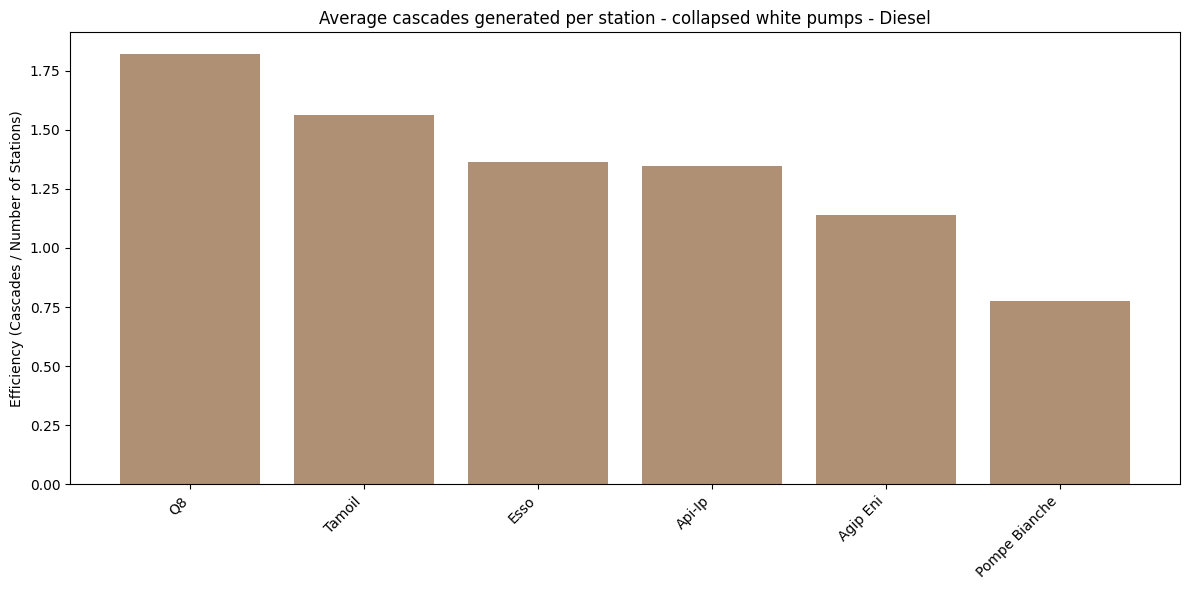

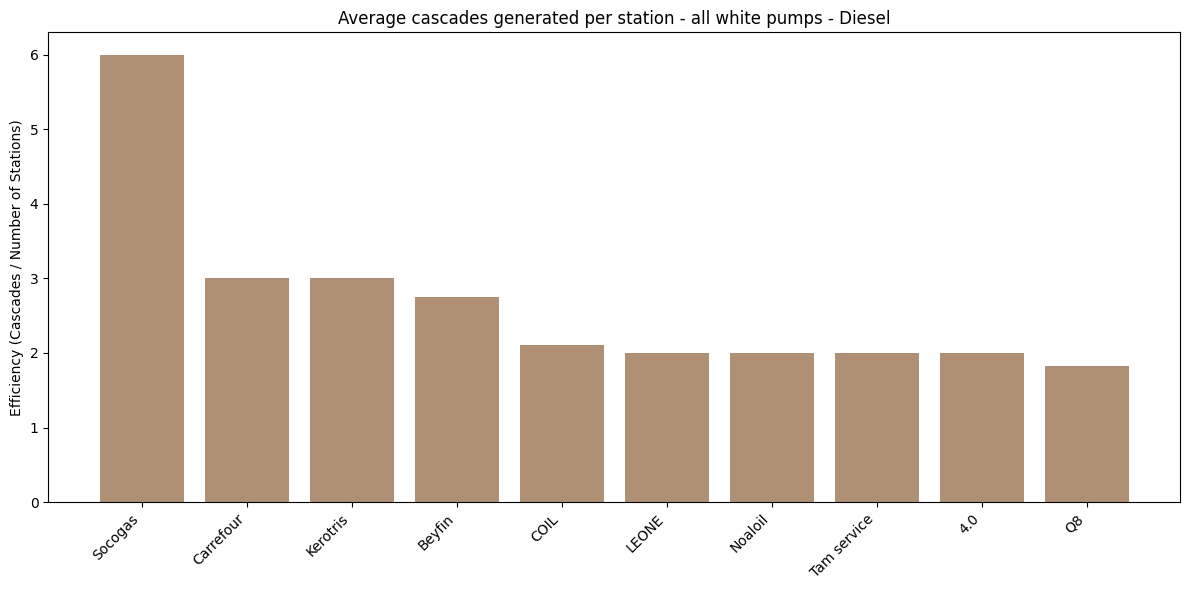

In [32]:
print("---GASOLINE---")
brand_influence_analysis(true_initiators_gasoline, lombardia_gasoline, True)
brand_influence_analysis(true_initiators_gasoline, lombardia_gasoline, False)

---DIESEL---


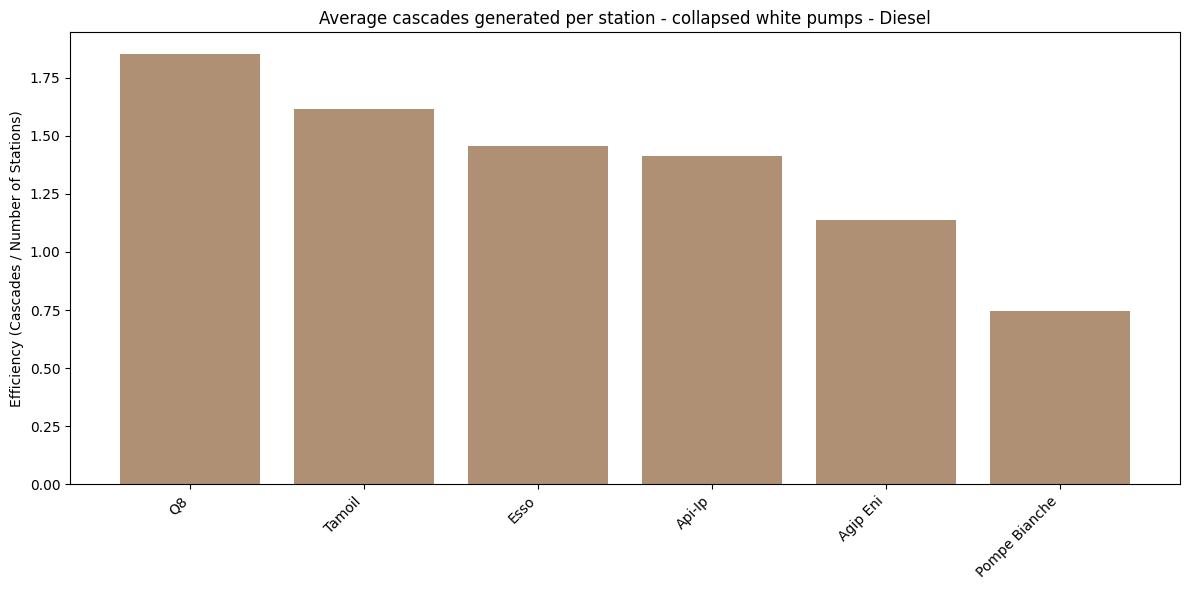

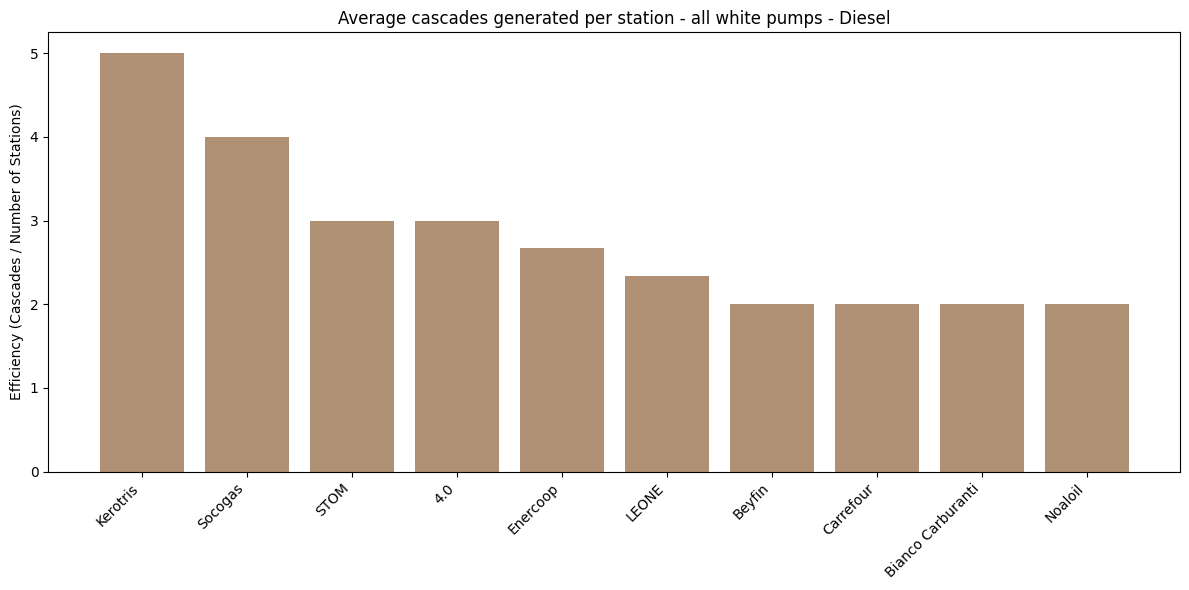

In [33]:
print("---DIESEL---")
brand_influence_analysis(true_initiators_diesel, lombardia_diesel, True)
brand_influence_analysis(true_initiators_diesel, lombardia_diesel, False)

### 4.2.3 Cascades and temporal pattern

We will now examine whether any temporal patterns emerge in cascade generation. As a reminder, this analysis focuses exclusively on cascades with a depth exceeding two, ensuring we are capturing significant price diffusion events rather than isolated reactions.

In [34]:
def cascades_dataframe(cascades):
    
    # Extract cascade start dates for gasoline cascades
    # We consider only cascades with more than 2 unique parents as we did before
    cascade_dates = []

    for node in cascades:
        for date_key in cascades[node]:
            cascade_list = cascades[node][date_key]
            unique_parents = {link["parent_index"] for link in cascade_list}
                
            if len(unique_parents) > 2:
                cascade_dates.append(date_key)

    # Convert to Pandas Series for easier analysis
    dates_series = pd.Series(cascade_dates)
    df_time = pd.DataFrame({'date': dates_series})
    
    return df_time

In [35]:
# Function to analyze the most frequent weekday for cascade initiation and visualize it with a bar chart
def most_frequent_weekday(cascades_df):
    

    cascades_df['weekday'] = cascades_df['date'].dt.day_name()

    # Counting occurrences per weekday
    weekly_pattern = cascades_df['weekday'].value_counts()

    # Ordering days of the week
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    weekly_pattern = weekly_pattern.reindex(days_order)

    # Preparing DataFrame for Plotly
    df_plot = weekly_pattern.reset_index()
    df_plot.columns = ['Day', 'Number of Cascades']

    # Plotting
    fig = px.bar(
        df_plot, 
        x='Day', 
        y='Number of Cascades',
        color='Number of Cascades', 
        color_continuous_scale='turbid',
        text_auto=True,
        title='Weekly Pattern',
        labels={'Number of Cascades': 'Total Events', 'Day': 'Day of the Week'}
    )

    fig.update_layout(
        xaxis_title=None,
        yaxis_title="Number of Cascades",
        title_x=0.5, 
        showlegend=False,
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()

In [36]:
# Function for plotting everyday the number of cascades initiated and highlighting 
# the days with anomalous activity (more than mean + 2*std)
def monthly_pattern(cascades_df):
    
    timeline = cascades_df['date'].value_counts().sort_index()
    threshold = timeline.mean() + 2 * timeline.std()

    # Plotly work better with DataFrames, so we convert the Series to a DataFrame
    cascades_df = timeline.reset_index()
    cascades_df.columns = ['Date', 'Cascades']

    # Plotting the timeline of cascades with Plotly
    fig = px.line(
        cascades_df, 
        x='Date', 
        y='Cascades',
        markers=True, # Add markers to the line for better visibility of individual points
        title='Number of Cascades per Day',
        labels={'Cascades': 'Intensity (N. Cascades)', 'Date': 'Day'}
    )

    fig.update_traces(line_color='#8f6139', marker_size=6)

    # 4. Aggiunta della Linea di Soglia (Threshold)
    fig.add_hline(
        y=threshold, 
        line_dash="dash", 
        line_color="red", 
        annotation_text="Threshold for Extreme Events (Mean + 2SD)", 
        annotation_position="top left"
    )

    # 5. (Opzionale ma figo) Evidenziamo i punti sopra la soglia con un colore diverso
    # Filtriamo i dati estremi
    outliers = cascades_df[cascades_df['Cascades'] > threshold]

    # Aggiungiamo un trace "scatter" solo per i punti rossi
    fig.add_trace(
        go.Scatter(
            x=outliers['Date'], 
            y=outliers['Cascades'],
            mode='markers',
            marker=dict(color='red', size=10, symbol='circle-open-dot'),
            name='Extreme Events',
            hoverinfo='skip' # L'hover lo fa già la linea principale
        )
    )

    # 6. Pulizia Layout
    fig.update_layout(
        template="plotly_white",
        hovermode="x unified", # Mostra una riga verticale quando passi col mouse
        title_x=0.5
    )

    fig.show()

    # Stampa testuale delle date calde
    print("Day with anomalous activity (Market Peaks):")
    # Usiamo il filtro pandas standard
    print(cascades_df[cascades_df['Cascades'] > threshold])

#### Gasoline

##### Weekly Pattern: The "Monday-Tuesday Effect"

The "Weekly Pattern" bar chart reveals a highly synchronized and transparent pricing strategy.

**Early-Week Dominance** Cascades do not occur at random. The vast majority are concentrated on Monday (1,737) and Tuesday (1,751). This confirms a well-known industry practice: managers receive new quotes or central directives (Platts) on Monday morning and adjust their prices between Monday and Tuesday.

**Weekly Decay:** Activity levels drop progressively throughout the week. Wednesday remains active (1,489), Thursday sees a decline (960), and from Friday to Sunday, the market enters a "hibernation" phase (with cascades dropping below 200).


##### Timeline and Anomalous Spikes: "The Three Waves"

The "Number of Cascades per Day" timeline identifies three specific moments when the market "went haywire" (the red-circled Extreme Events).

By correlating these dates with oil cycles or external shocks, we observe:

**Wave 1 (April 7–9):** A massive spike (up to 432 cascades in a single day). This likely represents an immediate reaction to a bullish oil price shock or a seasonal spring transition. It is a "choral" movement: nearly half the network moved in unison.

**Wave 2 (May 12–13):** A second spike (348 cascades). Interestingly, this occurs almost exactly one month after the first. It could indicate a monthly adjustment cycle or a delayed response to a previous price drop.

**Wave 3 (June 16–18):** The highest and most sustained peak (up to 446 cascades). Occurring in mid-June, this typically aligns with the anticipated increase in summer demand.

It appears that once a month, there are 2–3 days of intense market restructuring, followed by a period of stabilization for the remainder of the month.

**Conclusion on Timeline:** the market does not boil constantly. Instead, it experiences long periods of apparent calm interrupted by sudden bursts of synchronized activity. When a cascade starts, it is rarely an isolated incident; it is a mass contagion.

In [37]:
print("---GASOLINE---")
df_gasoline = cascades_dataframe(cascades_gasoline)
most_frequent_weekday(df_gasoline)
monthly_pattern(df_gasoline)

---GASOLINE---


Day with anomalous activity (Market Peaks):
         Date  Cascades
6  2025-04-07       432
7  2025-04-08       312
8  2025-04-09       313
36 2025-05-12       348
37 2025-05-13       322
69 2025-06-16       331
70 2025-06-17       396
71 2025-06-18       446


#### Diesel

The temporal analysis of deep cascades (depth > 2) for the Diesel market reveals patterns strikingly similar to Gasoline, confirming that the fuel market operates under a unified logic of synchronization and impulse-driven adjustments.


##### Weekly Pattern: The "Mid-Week Lag" Effect

The bar chart highlights a highly synchronized weekly pricing strategy, with a slight nuance compared to Gasoline.

**Early-Week Dominance:** Just like Gasoline, pricing activity is concentrated at the beginning of the week. Tuesday (1765 cascades) and Wednesday (1785 cascades) show the highest activity, slightly overtaking Monday (1615).
his slight shift towards Wednesday (compared to Gasoline's Monday/Tuesday peak) might suggest a "lag" in Diesel adjustments. Retailers may prioritize Gasoline updates first as it is the primary consumer product that non commercial user are looking for and adjust Diesel prices immediately after, or wait for commercial pricing signals which often solidify by mid-week.

The pattern of decay is identical. Activity drops sharply on Thursday (906) and flatlines from Friday through Sunday (< 200 events).
The market operates on a strictly "business day" logic. Consumers fueling up on weekends face "stale" prices that were decided 3-4 days prior.


##### Timeline Analysis: Punctuated Equilibrium

The chart confirms that the Diesel market also follows a "pulse" dynamic rather than a continuous flow. The market remains in a state of low-level fluctuation (noise) punctuated by three distinct, massive waves of coordinated repricing.

**Wave 1: Early April (around April 6-8):** A sharp spike reaching ~360 cascades.
This marks the first synchronized market adjustment of the period.


**Wave 2: Mid-May (around May 12-14):** A second, slightly higher wave reaching ~400 cascades.
The timing is consistent with the monthly cycle observed in Gasoline, reinforcing the hypothesis of a monthly reset behavior where retailers accumulate cost changes and release them in a single burst.


**Wave 3: Mid-June (around June 16-18):** The most intense event, peaking at over 550 cascades.
*This is the most violent adjustment of the observed period. The sheer magnitude suggests a rush effect where the entire network moved simultaneously, likely driven by pre-summer demand expectations or a significant jump in wholesale diesel costs.

In [38]:
print("---DIESEL---")
df_diesel = cascades_dataframe(cascades_diesel)
most_frequent_weekday(df_diesel)
monthly_pattern(df_diesel)

---DIESEL---


Day with anomalous activity (Market Peaks):
         Date  Cascades
6  2025-04-07       357
40 2025-05-13       353
41 2025-05-14       400
73 2025-06-17       362
74 2025-06-18       550


### 4.2.4 Total impact, frequency x depth of cascades

Now we are going to visualize on a map the stations that propagate their influence the most. To calculate the influence, we create a score called **"Total Impact"**, which is based on the **sum of the depths** of all valid cascades (those extending beyond 2 steps) initiated by a station. This metric effectively combines **frequency** (how often a station starts a trend) with **reach** (how far that trend travels), allowing us to identify the true "power players" in the network. The result is displayed on an interactive map where the size and color of each point correspond to this cumulative impact score, highlighting the most influential price setters in the region.

In [39]:
import plotly.express as px
import pandas as pd
import numpy as np

def map_initiators(cascades, true_initiators, price_network):
    initiator_stats = []

    # For every real initiator, calculate stats
    for node in true_initiators:
    
        depths = []
        
        # For every cascade started by this node (on different dates)
        # we analyze the depth reached
        for date in cascades[node]:
            cascade_list = cascades[node][date]
            
            actual_depth = set()
            
            for step in cascade_list:
                
                actual_depth.add(step['parent_index'])
                        
            if len(actual_depth) > 2: 
                depths.append(len(actual_depth))
        
        # If there are valid depths, calculate stats
        if depths:
            
            # Frequence and Average Depth
            count = len(depths)          
            avg_depth = np.mean(depths) 
            
            # "Total Impact": Sum of every depth reached in each cascade
            # Combines Frequency and Depth into a single number.
            # Example: 10 cascades with depth 3 = Score 30.
            #          2 cascades with depth 15 = Score 30.
            total_impact = np.sum(depths) 

            # Get geographical and brand info
            node_props = price_network.node(node).properties
            lat = float(node_props["Latitudine"])
            lon = float(node_props["Longitudine"])
            brand = node_props["Bandiera"]

            initiator_stats.append({
                'Node': node,
                'Brand': brand,
                'Lat': lat,
                'Lon': lon,
                'Avg_Depth': avg_depth,
                'Count': count,
                'Total_Impact': total_impact
            })

    # Create DataFrame for visualization
    df_map = pd.DataFrame(initiator_stats)

    print(f"\nData collected: {len(df_map)} rows.")

    if not df_map.empty:
        # Sort the dataframe so that the most important dots are drawn LAST (on top of others)
        df_map = df_map.sort_values(by="Total_Impact", ascending=True)

        fig = px.scatter_map(
            df_map,
            lat="Lat",
            lon="Lon",
            hover_name="Brand",
            # Add Total_Impact to hover
            hover_data={"Node": True, "Avg_Depth": ":.2f", "Count": True, "Total_Impact": True, "Lat": False, "Lon": False},
            
            color="Total_Impact",      # COLOR now represents total power (Freq * Depth)
            size="Total_Impact",       # SIZE now represents total power (Freq * Depth)
            
            color_continuous_scale="solar", 
            range_color=[0, 500],      # Fix color scale from 0 to 500
            
            size_max=25,
            zoom=7.9,
            title="<b>Total Impact Map:</b> Frequency × depth of cascades initiated by stations",
    
            map_style="carto-darkmatter",
            
            width=1400,
            height=900
        )
        
        max_teoric = 500
        size_ref = (2.0 * max_teoric) / (25**2) # 25 is the max size in pixels we set for the biggest dot
        fig.update_traces(marker=dict(sizeref=size_ref, sizemin=1))
        
        fig.update_layout(title_x=0.5)
        fig.show()
        
    return initiator_stats

The maps presented illustrate the geographic distribution of the "Total Impact Score" for gasoline and diesel stations in Lombardy. Each point represents a station, where the color (ranging from dark red to bright yellow) and marker size highlight its ability to generate extensive price ripple effects.

The most evident finding across both maps is that market influence is not homogeneously distributed but is instead highly polarized. The absolute epicenters of contagion (the high-intensity yellow clusters) are concentrated in two macro-areas: the heart of the Milan metropolitan area and its North-West hinterland, and the strategic axis of the Varese area, particularly the Busto Arsizio / Gallarate hub. These zones correspond to the region’s highest population, industrial, and commuting densities. The high concentration of stations in these confined spaces creates a hyper-competitive environment: a price drop in these neuralgic hubs triggers a chain reaction that spreads rapidly to neighboring stations. Conversely, vast peripheral areas (Southern Lombardy and Alpine valleys) appear dark, indicating stations that operate as "price takers" or within local micro-monopolies, unable to trigger deep cascades.

The Gasoline map reflects a market oriented toward the final consumer and driven by neighborhood dynamics. No single node reaches the extreme peaks observed in the diesel market (maximum values peak between 300 and 350, remaining in the orange-yellow range). However, high-impact nodes are numerically superior and more widely distributed. The entire Milan area, its vast hinterland, and the corridor toward Varese are lit by multiple medium-to-high intensity epicenters. Here, competition is fought "street by street": numerous local leaders trigger neighborhood or provincial price wars, creating a contagion network that is more fragmented, reactive, and complex to predict than that of diesel.

The Diesel map, meanwhile, reveals a market governed by a highly centralized logic. The single node with the absolute highest triggering capacity (the large bright yellow marker peaking at 450-500) belongs to the diesel market and is located North of Milan, specifically in Cinisello Balsamo. Aside from this "super influencer" and a secondary cluster on the North-West axis (Varese/Busto Arsizio), the rest of the territory remains dark. This indicates that the vast majority of distributors accept prices passively. Being a market strictly tied to logistics and commercial fleets, a few high-volume neuralgic hubs are sufficient to dictate the price line to dozens of subordinate stations.

In [40]:
print("---GASOLINE---")
initiators_gasoline = map_initiators(cascades_gasoline, true_initiators_gasoline, lombardia_gasoline)

---GASOLINE---

Data collected: 1416 rows.


In [41]:
print("---DIESEL---")
initiators_diesel = map_initiators(cascades_diesel, true_initiators_diesel, lombardia_diesel)

---DIESEL---

Data collected: 1428 rows.


A comparative analysis of the top 100 nodes by Total Impact versus 1_Influencers reveals a minimal overlap between the two cohorts. This divergence suggests that represent distinct structural mechanisms within the network: while some nodes facilitate global reach, others drive direct local engagement. The lack of correlation indicates that these two forms of systemic power are functionally independent.

In [42]:
# Function to compare the first 100 influencers based on their Total Impact score 
# and check how many of them are actually marked as influencers in the price matching network
def compare_influencers(initiators, price_matching_network):
    
    node_point = {}
    
    for i in initiators:
        node_point[i['Node']] = float(i['Total_Impact'])

    node_point = {k: v for k, v in sorted(node_point.items(), key=lambda item: item[1], reverse=True)}

    node_point = dict(list(node_point.items())[:100])

    index = 0
    for i in node_point:
        
        is_inf = price_matching_network.nodes[i]['1_influencer']
        
        if is_inf:
            index += 1

    print(index)
    
compare_influencers(initiators_gasoline, price_matching_network_gasoline_3km)
compare_influencers(initiators_diesel, price_matching_network_diesel_3km)

16
3


-----------------------------------------------------------------------

CODE IDEA TO WORK ON

In [ ]:

if not df_map.empty:
    top_node = df_map.sort_values(by="Total_Impact", ascending=False).iloc[0]
    target_node_id = top_node['Node']
    print(f"Visualizziamo la cascata del nodo top: {target_node_id} ({top_node['Brand']})")
    
    # Prendiamo la data di inizio della sua cascata più grossa
    # (Dobbiamo cercare nel dizionario originale per trovare la data giusta)
    target_date = None
    max_len = 0
    for d in cascades_gasoline[target_node_id]:
        if len(cascades_gasoline[target_node_id][d]) > max_len:
            max_len = len(cascades_gasoline[target_node_id][d])
            target_date = d
            
    print(f"Start date: {target_date}")
else:
    print("No data available to identify top node.")

Visualizziamo la cascata del nodo top: 38380 (Api-Ip)
Data di inizio evento: 2025-04-07 00:00:00


In [44]:
nodes = {}
edges = []

index = 1
for edge in cascades_gasoline["38380"][datetime.datetime(2025, 4, 7)]:
    
    edges.append({
        "id": index,
        "source": edge["src"],
        "target": edge["dst"],
        "date": edge["date"]})

    index += 1

df = pd.DataFrame(edges)
# index=False evita di scrivere i numeri di riga (0, 1, 2...) nel file
df.to_csv("output.csv", index=False)

-----------------------------------------------------------------------------------

# 5 Analysis on 3km undirected network

Having analyzed the directional flow of influence, we now transform the network from Directed to Undirected. This allows us to shift our focus from 'who triggers whom' to the broader underlying structural connectivity and communal patterns within the market.

In [44]:
# Make the price matching networks undirected for further analysis
price_matching_network_gasoline_3km_u = price_matching_network_gasoline_3km.to_undirected()
price_matching_network_diesel_3km_u = price_matching_network_diesel_3km.to_undirected()

# Extract the degree values of nodes in the undirected price matching network
degree = dict(price_matching_network_gasoline_3km_u.degree(weight = 'weight'))
degree_values = list(degree.values())

## 5.1 Degree distribution

Trying to understand if the degree distribution follows a power law, by plotting the fit of the data into a power law and the empirical data.

The hump formed in the graph suggest that the empirical data are not distributed like a power law.

Values less than or equal to 0 in data. Throwing out 0 or negative values


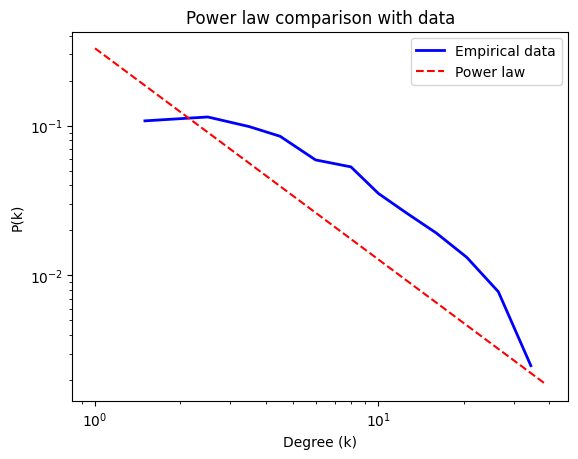

In [45]:
import matplotlib.pyplot as plt
import powerlaw

# Distribution fit
fit = powerlaw.Fit(degree_values, xmin=1, discrete=True)

# Plotting the degree distribution and the power law fit
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.legend()
plt.title("Power law comparison with data")
plt.show()

Checking if the distribution of the data is more likely to be a power law than a exponential or lognormal distribution.

In both cases it's more likely to be a exponential or a lognormal.

In [46]:
# Power law vs exponential comparison
R, p = fit.distribution_compare('power_law', 'exponential')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation:
# - R > 0 and p < 0.05 --> more likely power law
# - R < 0 and p < 0.05 --> more likely exponential
# - p high → non significant difference

Likelihood ratio R: -1119.1126902873893
p-value: 5.844406788454104e-256


In [47]:
# Power law vs lognormal comparison
R, p = fit.distribution_compare('power_law', 'lognormal')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation:
# - R > 0 and p < 0.05 --> more likely power law
# - R < 0 and p < 0.05 --> more likely lognormal
# - p high → non significant difference

Likelihood ratio R: -1051.004504795126
p-value: 9.708210128449234e-212


Plotting the power law, exponential, lognormal and the empirical data in order to see which one is far more likely to be.

After the comparisons the most suitable distribution seems to be the exponential.


----Comparisons----

power_law vs exponential: R=-1119.113, p=0.000
more likely to be a exponential distibution

power_law vs lognormal: R=-1051.005, p=0.000
more likely to be a lognormal distibution

lognormal vs exponential: R=-68.108, p=0.000
more likely to be a exponential distibution



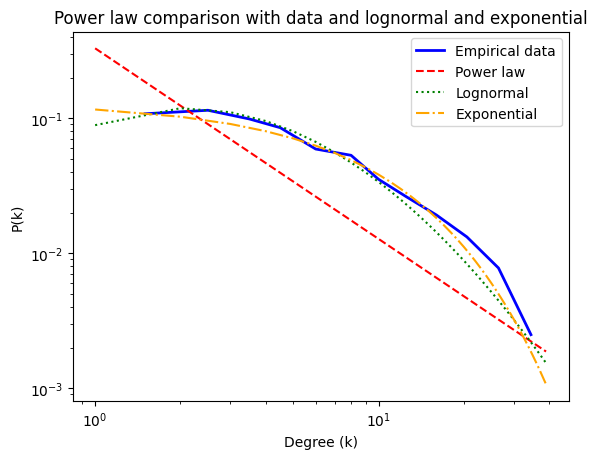

In [48]:
# Statistical comparisons between power law, lognormal and exponential
def comparison(fit, dist1, dist2):
    R, p = fit.distribution_compare(dist1, dist2)

    dist1 = '\033[91m' + dist1 + '\033[0m'
    dist2 = '\033[91m' + dist2 + '\033[0m'

    print(f"{dist1} vs {dist2}: R={R:.3f}, p={p:.3f}")

    if p < 0.05:

        if R > 0:
            print(f"more likely to be a {dist1} distibution")
        else:
            print(f"more likely to be a {dist2} distibution")

    else:
        print("No significant difference")
    
    print("")

print("\n----Comparisons----\n")
comparison(fit, 'power_law', 'exponential')
comparison(fit, 'power_law', 'lognormal')
comparison(fit, 'lognormal', 'exponential')


# Graph for comparisons
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law')
fit.lognormal.plot_pdf(color='g', linestyle=':', ax=fig, label='Lognormal')
fit.exponential.plot_pdf(color='orange', linestyle='-.', ax=fig, label='Exponential')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.legend()
plt.title("Power law comparison with data and lognormal and exponential")
plt.show()


Another test to confirm that the degree distribution follows a exponential distribution.

Estimate the **expected value** of the distribution using the **sample mean**, this beacuse the mean is always a **non-deviant estimator** for calculating the **expected value**.

Using the expected value **lambda** we can calculate the **variance** of the distribtution that is **1/(lambda^2)**.

After that we can calculate the variance using the empirical data to estimate the variance of the distribution, if the two parameter are similar we are dealing with a exponential distribution, in this case the variance is very similar, it is very likely that the degree follows a exponential distribution.

In [49]:
import statistics

mean = statistics.mean(degree_values)

# For an exponential distribution, the expected valuse is called lambda
lambda_value = 1 / mean

# The variance of an exponential distribution is given by 1/(lambda^2)
expon_variance = 1 / (lambda_value ** 2)

# 
variance = statistics.variance(degree_values)

print("The difference between the sample variance and the estimated distribution variance is",abs(expon_variance-variance))

The difference between the sample variance and the estimated distribution variance is 1.073962135801473


The degree distribution follows an Exponential law, definitively rejecting the Scale-Free (Power Law) hypothesis.

This result is consistent with the spatial nature of the network, governed by the 3km geometric constraint.
It also confirms the absence of dominant global hubs. In this network, no single station can "reach" the entire country; influence is physically capped.
The topology suggests a market composed of homogeneous local clusters. This further supports the evidence that price leadership is a distributed and local phenomenon, rather than a centralized one.

----------------------------------------------------------------------------------------------

## 5.2 Media prices and new matching

I calculated the median price of every node based on the prices history, I am not using the mean because a node has a price histori of 91 observation, the mean over such a large dataset it's not the best way to extract only one representative value so instead I opted for the median.

In [50]:
# Calculate the median price for each node in the price matching network
# This is used to assign a representative price to each station based on its historical prices
def median_price(network, price_network):
    node_median_price = {}

    for node in network.nodes(data=True):

        # Extract the price history for the node
        history = price_network.node(node[0]).history()

        # If there are less than 2 price entries, use the current price as the median
        price_median = float(price_network.node(node[0]).properties["prezzo"])

        # Calculate the median price if there are more than 2 price entries
        if len(history) > 2:
            prices = list()
            for date in history:
                prices.append(float(price_network.node(node[0]).at(date).properties["prezzo"]))

            price_median = round(statistics.median(prices),3)

        # Store the median price in the node_median_price dictionary
        node_median_price[node[0]] = price_median
        node[1]["price"] = price_median

    return node_median_price

gasoline_median = median_price(price_matching_network_gasoline_3km_u, lombardia_gasoline)
diesel_median = median_price(price_matching_network_diesel_3km_u, lombardia_diesel)

Until now the edges never have had a weight because we converted from directed to undirected, with this function we can set the weight of the edges as one of the matching day, this will be useful for some metrics that we weill be calculated.

If the matching to put as weight is 0 I can copy it without problem, if is greater than 0 I have to take into consideration the matching from node **A** to **B** and from **B** to **A** making the average fot the two and putting it as weight.

I decided for the same reasons showed before to put as weight the 1_matching.

In [51]:
# Function to set edge weights in the price matching network based on the name of a given attribute
# The edge weight is set to the value of the attribute, with a minimum value of 1 to avoid zero weights
# This is important for certain network analyses that require positive weights like distinctiveness centrality
# For example, if the attribute is "0_matching", the edge weight will be set to the value of "0_matching"
def set_edge_weight(network_u, network_d, attribute):

    for edge in network_u.edges(data=True):

        if attribute == "0_matching":
            aux = edge[2][attribute]
        else:
            aux = (network_d[edge[0]][edge[1]][attribute] + network_d[edge[1]][edge[0]][attribute]) / 2

        if aux < 1:
            aux = 1

        edge[2]["weight"] = aux

set_edge_weight(price_matching_network_gasoline_3km_u, price_matching_network_gasoline_3km, "1_matching")
set_edge_weight(price_matching_network_diesel_3km_u, price_matching_network_diesel_3km, "1_matching")

## 5.3 Correlation between prices and centralities

I calculated some centrality measures, some of these use the weight of the edges this is the reason for the previous function.

I choose some of the metrics used in a paper that tries to find a correlation between this metrics and the gasoline prices in some Italian cities.

https://doi.org/10.1016/j.cities.2024.105075

In [52]:
import json

def centrality_calc(network):
    from distinctiveness.dc import distinctiveness

    centrality_type = {}

    centrality_type["Degree_centr"] = nx.degree_centrality(network)

    centrality_type["Betweenness"] = nx.betweenness_centrality(network, normalized=True)

    centrality_type["Closeness"] = nx.closeness_centrality(network)

    centrality_type["Eigen_no_w"] = nx.eigenvector_centrality(network, max_iter=1000, weight=None)

    centrality_type["Eigen_w"] = nx.eigenvector_centrality(network, max_iter=1000, weight="weight")

    centrality_type["Laplacian"] = nx.laplacian_centrality(network)

    D1 = distinctiveness(network, alpha = 1, normalize=True, measures = ["D1"])
    centrality_type["Distinctive"] = D1["D1"]

    return centrality_type

# Check if the centrality measures for the price matching networks already exist
# If they do, load them; otherwise, calculate the centrality measures
# and save them to JSON files
# This avoids recalculating the centrality measures if they have already been computed
# and stored in the specified directory
# The JSON files are named according to the fuel type
# For example, for gasoline, the file name is:
# "centrality_price_matching_network_gasoline_3km_u.json"
# and for diesel, the file name is:
# "centrality_price_matching_network_diesel_3km_u.json"
if (os.path.exists(f"../network/centrality_price_matching_network_gasoline_3km_u.json") 
and os.path.exists(f"../network/centrality_price_matching_network_diesel_3km_u.json")):

    with open("../network/centrality_price_matching_network_gasoline_3km_u.json", "r") as f:
        data = f.read()
        gasoline_centrality = json.loads(data)
    
    with open("../network/centrality_price_matching_network_diesel_3km_u.json", "r") as f:
        data = f.read()
        diesel_centrality = json.loads(data)

else:
    gasoline_centrality = centrality_calc(price_matching_network_gasoline_3km_u)
    with open("../network/centrality_price_matching_network_gasoline_3km_u.json", "w") as f:
        json.dump(gasoline_centrality, f, indent=4)
    
    diesel_centrality = centrality_calc(price_matching_network_diesel_3km_u)
    with open("../network/centrality_price_matching_network_diesel_3km_u.json", "w") as f:
        json.dump(diesel_centrality, f, indent=4)

Calculating the correlation between the centrality metrics and the median price.

In [53]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# Function to calculate and print the Spearman and Pearson correlation coefficients
# between the median prices and a given centrality measure
def correlation_price_centrality(price,centrality,type):

    # Build a DataFrame with centrality and median price for each station
    df = pd.DataFrame({
    "station_id": list(price.keys()),
    "centrality": [centrality[n] for n in list(price.keys())],
    "price_median": [price[n] for n in list(price.keys())]
    })

    # Calculate Spearman and Pearson correlation coefficients
    rho_s, p_s = spearmanr(df["centrality"], df["price_median"])
    rho_p, p_p = pearsonr(df["centrality"], df["price_median"])
    print(f"{type} \t --> Spearman r={rho_s:.3f} (p={p_s:.3f}), Pearson r={rho_p:.3f} (p={p_p:.3f})")

# Correlate centrality measures with median prices for gasoline and diesel
print("\n---Correlation gasoline centrality vs median price---")
for centrality in gasoline_centrality:
    correlation_price_centrality(gasoline_median, gasoline_centrality[centrality], centrality)

print("\n---Correlation diesel centrality vs median price---")
for centrality in diesel_centrality:
    correlation_price_centrality(diesel_median, diesel_centrality[centrality], centrality)


---Correlation gasoline centrality vs median price---
Degree_centr 	 --> Spearman r=-0.175 (p=0.000), Pearson r=-0.022 (p=0.249)
Betweenness 	 --> Spearman r=-0.161 (p=0.000), Pearson r=-0.024 (p=0.209)
Closeness 	 --> Spearman r=-0.174 (p=0.000), Pearson r=-0.031 (p=0.115)
Eigen_no_w 	 --> Spearman r=-0.180 (p=0.000), Pearson r=-0.077 (p=0.000)
Eigen_w 	 --> Spearman r=-0.157 (p=0.000), Pearson r=0.011 (p=0.580)
Laplacian 	 --> Spearman r=-0.275 (p=0.000), Pearson r=-0.170 (p=0.000)
Distinctive 	 --> Spearman r=-0.283 (p=0.000), Pearson r=-0.252 (p=0.000)

---Correlation diesel centrality vs median price---
Degree_centr 	 --> Spearman r=-0.060 (p=0.002), Pearson r=0.067 (p=0.001)
Betweenness 	 --> Spearman r=-0.036 (p=0.060), Pearson r=0.017 (p=0.383)
Closeness 	 --> Spearman r=-0.029 (p=0.141), Pearson r=0.075 (p=0.000)
Eigen_no_w 	 --> Spearman r=-0.035 (p=0.073), Pearson r=-0.045 (p=0.020)
Eigen_w 	 --> Spearman r=-0.033 (p=0.088), Pearson r=-0.090 (p=0.000)
Laplacian 	 --> Spearm

##### Does centrality mean cheaper prices?

The correlation analysis between various network centrality metrics and the median price of each station reveals a consistent and intriguing pattern: **Being central is associated with being cheaper.**

Across both Gasoline and Diesel markets, the Spearman correlations are consistently **negative**. This means that as a station's centrality increases (whether measured by Degree, Closeness, or Eigenvector), its median price tends to decrease.

**The "Competitive Discount" Effect:** The negative correlation suggests that stations located in highly connected or central areas face greater competitive pressure. To survive in a "high-degree" neighborhood (surrounded by many rivals), stations are forced to lower their prices. Conversely, isolated stations (low centrality) can exploit their local monopoly to charge higher prices.

**Laplacian & Distinctive Centrality are Key:** Interestingly, the strongest negative correlations are found with **Laplacian Centrality** (Spearman r ≈ -0.275 for Gasoline) and **Distinctive Centrality**. These advanced metrics, which often highlight nodes that bridge different communities or hold unique structural positions, are better predictors of lower prices than simple Degree centrality. This implies that stations acting as "bridges" or key hubs are the most aggressive in pricing.

**Diesel vs. Gasoline:** The effect is noticeably stronger for Gasoline (r ≈ -0.17 to -0.28) than for Diesel (r ≈ -0.06 to -0.18). This confirms that the gasoline market is more sensitive to spatial competition than the commercial diesel market, where location might be less critical than contract pricing.

------------------------------------------------------------------------------------------------

## 5.4 Community detection, Louvain through ANOVA

This section of the code represents an attempt to identify distinct pricing communities within the network. Instead of accepting administrative boundaries (like municipalities or provinces) as the default market definition, we let the data speak for itself to find the true economic boundaries.

The core logic relies on a statistical optimization loop that combines Network Theory (Community Detection) with Classical Statistics (ANOVA).

##### Louvain
The algorithm uses the Louvain Method, a popular community detection algorithm, to group fuel stations that are strongly connected in the network. However, the Louvain method has a tunable parameter called resolution, which dictates the size of the communities:

A low resolution finds few, giant communities.

A high resolution fragments the network into many tiny neighborhoods.


##### ANOVA
To decide which level of granularity is the correct one for the Lombardy market, the code introduces a statistical judge: the ANOVA F-Statistic.
For every possible community configuration, the algorithm asks: "Are the prices within these groups similar to each other, but different from the prices in other groups?"

If the F-Statistic is low, the communities are meaningless (prices are mixed up).

If the F-Statistic is high, the communities represent distinct "Price Zones" (e.g., a cheap zone vs. an expensive zone).


##### How it works
The code runs a simulation, adjusting the resolution step by step. It seatch for the resolution that maximizes the signal (the F-Statistic). It employs an early stopping mechanism to halt the search once the best possible separation between price zones is found, preventing the algorithm from overfitting or running indefinitely.

The result is visually validated using boxplots. These plots order the discovered communities from cheapest to most expensive, allowing us to visually confirm that the algorithm has successfully separated the network into clusters with distinct pricing behaviors, proving that spatial location is a significant determinant of price.


In [54]:
import networkx as nx
from scipy.stats import f_oneway
import numpy as np

# Function to perform ANOVA test on communities detected in the network
# using the Louvain method for community detection
# The function optimizes the resolution parameter to maximize the F-statistic
def anova_community_test_optimized(price_median, price_matching_network, step=0.1):
    
    res = 1.0
    best_F = -1
    best_partition = None
    best_res = 1.0
    
    # Parameters for early stopping
    patience = 20
    counter = patience
    
    
    print(f"Starting ANOVA optimization (Step {step})...")
    
    while True:
        # Louvain community detection
        # Using fixed seed for reproducibility
        communities = nx.community.louvain_communities(price_matching_network, weight='weight', resolution=res, seed=42)
        
        # Filter out small communities (< 2 members) that break ANOVA
        valid_communities = [list(c) for c in communities if len(c) > 1]
        
        # If we have fewer than 2 valid groups, ANOVA cannot be performed.
        # Continue searching by increasing the resolution (splitting groups)
        if len(valid_communities) < 2:
            res += step
            continue

        # Prepare prices for ANOVA
        # We create a list of price lists, one for each community, to feed into the ANOVA test.
        groups_prices = []
        for com in valid_communities:
            prices = [price_median[node] for node in com if node in price_median]
            groups_prices.append(prices)
        
        # If after filtering prices we have fewer than 2 groups, skip
        if len(groups_prices) < 2:
            res += step
            continue

        # Calculate F-Statistic and P-value using ANOVA
        try:
            F_actual, p_value = f_oneway(*groups_prices)
        except:
            F_actual = 0 # Handle errors if variance is zero
            
        # Logic of the "Best Model"
        # We want to maximize the F-Statistic, which indicates better separation between groups.
        # If we find a new best F-Statistic, we save the partition and reset the patience counter.
        # If we do not find a better F-Statistic, we decrease the counter. If the counter reaches zero, we stop the search.
        # This allows us to find a good resolution parameter without overfitting or endlessly searching.
        # 
        if F_actual > best_F:
            best_F = F_actual
            best_partition = valid_communities
            best_res = res
            counter = patience # Reset 
            # print(f"New Best: Res={res:.1f}, F={F_actual:.2f}") # debug
        else:
            counter -= 1
        
        # Exit condition
        if counter == 0:
            print(f"STOP. Best result found at Res={best_res:.1f} with F-Score={best_F:.2f}")
            break
            
        # Infinite loop protection (if res becomes absurdly high)
        if res > 10.0: 
            print("Resolution limit reached.")
            break

        res += step


    # Final assignment to the graph
    if best_partition:
        # Clean old attributes
        for n in price_matching_network.nodes:
            #This attribute will store the optimized community label for each node. We initialize it to -1 (indicating no community) before assigning the new labels.
            price_matching_network.nodes[n]["optimized_com"] = -1
        
        # Assign new community labels
        for i, com in enumerate(best_partition):
            for n in com:
                price_matching_network.nodes[n]["optimized_com"] = str(i)
    
    print(best_F, p_value)
    
    
    # Boxplot for visual validation of the ANOVA results
    plot_data = []

    for node, attr in price_matching_network.nodes(data=True):
        community = attr["optimized_com"]
        
        # Ignore outliers (-1) and take only the top communities
        if community != -1:
            price = price_median.get(node)
            if price:
                plot_data.append({"Community": community, "Price": price })

    df_anova = pd.DataFrame(plot_data)

    # Filter only the largest communities for clarity
    top_communities = df_anova['Community'].value_counts().head(15).index
    df_anova_filtered = df_anova[df_anova['Community'].isin(top_communities)]

    # Ordering communities by median price for better visualization
    order = df_anova_filtered.groupby("Community")["Price"].median().sort_values().index

    fig = px.box(
        df_anova_filtered, 
        x="Community", 
        y="Price",
        color="Community",
        category_orders={"Community": order}, # Ascending order by median price
        title=f"ANOVA Validation: price zone (F-Score: {best_F:.2f})",
        template="plotly_white"
    )
    fig.show()
    
    return best_partition, best_F, df_anova

##### Structural Differences in Community Dynamics: Gasoline vs. Diesel

The comparison of the **Box Plots** across the optimal communities reveals a structural divergence between the two fuel types.

**Gasoline:** The gasoline communities exhibit almost zero internal variance (highly compressed boxes). This indicates **near perfect price matching** within each cluster; the price signal travels fast and is followed strictly.

**Diesel:** Conversely, Diesel shows significantly higher intra-community variance (vertically extended boxes). This visual evidence that the diesel market is less reactive to neighborhood topological dynamics.

**The Economic Rationale:** This is likely due to the nature of demand. While gasoline is a typical B2C (Business-to-Consumer) product, Diesel is heavily driven by **B2B/Fleet demand**. For professional transport, the "board price" (the price displayed on the totem) is often less critical than private contracts, fuel cards, or discounts, making the public price a less rigid variable than it is for gasoline.


In [55]:
best_coms_gasoline, f_score_gasoline, df_anova_gasoline = anova_community_test_optimized(gasoline_median, price_matching_network_gasoline_3km_u)
best_coms_diesel, f_score_diesel, df_anova_diesel = anova_community_test_optimized(diesel_median, price_matching_network_diesel_3km_u)

Starting ANOVA optimization (Step 0.1)...
Resolution limit reached.
11.088107688546469 1.166372417516437e-252


Starting ANOVA optimization (Step 0.1)...
STOP. Best result found at Res=5.9 with F-Score=14.36
14.362974990492177 4.958706086151705e-216


## 5.5 Correlation between price difference and matching

Now we want to check the correlation in the difference in price between two stations and the level of matching.

In [56]:
# Function to analyze the correlation between the price difference of connected nodes and their edge matching value
def correlation_price_matching(network, price_median):
    matching = {}
    price_difference = {}

    for edge in network.edges(data=True):
        number = edge[2]["id"]

        matching[number] = edge[2]["weight"]
        price_difference[number] = abs(price_median[edge[0]] - price_median[edge[1]])

    df = pd.DataFrame({
        "edge_id": list(matching.keys()),
        "matching": [matching[n] for n in list(matching.keys())],
        "price_diff": [price_difference[n] for n in list(matching.keys())]
    })

    rho_s, p_s = spearmanr(df["matching"], df["price_diff"])
    rho_p, p_p = pearsonr(df["matching"], df["price_diff"])
    print(f"Lag {lag} --> Spearman r={rho_s:.3f} (p={p_s:.3f}), Pearson r={rho_p:.3f} (p={p_p:.3f})")

print("\n---Correlation gasoline edge matching vs difference in price---")
for lag in range (0,6):
    # The edge weight is set to the value of the matching attribute for the given lag. For example, if lag=2, the edge weight will be set to the value of "2_matching". 
    # This allows us to analyze how the correlation between price difference and matching changes as we consider different lags in the price matching network.
    set_edge_weight(price_matching_network_gasoline_3km_u, price_matching_network_gasoline_3km, f"{lag}_matching")
    correlation_price_matching(price_matching_network_gasoline_3km_u, gasoline_median)

print("\n---Correlation diesel edge matching vs difference in price---")
for lag in range (0,6):
    set_edge_weight(price_matching_network_diesel_3km_u, price_matching_network_diesel_3km, f"{lag}_matching")
    correlation_price_matching(price_matching_network_diesel_3km_u, diesel_median)


---Correlation gasoline edge matching vs difference in price---
Lag 0 --> Spearman r=-0.852 (p=0.000), Pearson r=-0.451 (p=0.000)
Lag 1 --> Spearman r=-0.853 (p=0.000), Pearson r=-0.464 (p=0.000)
Lag 2 --> Spearman r=-0.857 (p=0.000), Pearson r=-0.466 (p=0.000)
Lag 3 --> Spearman r=-0.860 (p=0.000), Pearson r=-0.471 (p=0.000)
Lag 4 --> Spearman r=-0.861 (p=0.000), Pearson r=-0.475 (p=0.000)
Lag 5 --> Spearman r=-0.862 (p=0.000), Pearson r=-0.478 (p=0.000)

---Correlation diesel edge matching vs difference in price---
Lag 0 --> Spearman r=-0.837 (p=0.000), Pearson r=-0.412 (p=0.000)
Lag 1 --> Spearman r=-0.842 (p=0.000), Pearson r=-0.427 (p=0.000)
Lag 2 --> Spearman r=-0.851 (p=0.000), Pearson r=-0.430 (p=0.000)
Lag 3 --> Spearman r=-0.857 (p=0.000), Pearson r=-0.436 (p=0.000)
Lag 4 --> Spearman r=-0.860 (p=0.000), Pearson r=-0.441 (p=0.000)
Lag 5 --> Spearman r=-0.862 (p=0.000), Pearson r=-0.445 (p=0.000)


##### The "Mirror Effect": Strong Correlation between Matching and Price Similarity

This analysis investigates the relationship between the **"Matching Score"** (how synchronized two stations are in their price changes over time) and their **Difference in Price** (the absolute gap between their median price levels).

**Massive Negative Correlation:**
Across all time lags (0 to 5 days) and both fuel types, we observe extremely high negative Spearman correlations, ranging from **-0.85 to -0.86**.
There is an almost perfect inverse relationship. **High Matching = Low Price Difference:** Pairs of stations that frequently move their prices together (high synchronization) tend to have nearly identical price levels. They are not just copying the timing of the change; they are converging to the same price point.
**Low Matching = High Price Difference:** Stations that do not synchronize their moves tend to have large price gaps between them.


**Temporal Consistency:**
The correlation remains incredibly stable and strong from Lag 0 (same-day matching) up to Lag 5. This suggests that the "alignment" between competitors is not a fleeting phenomenon but a structural feature of the market. If two stations are "strategic pairs," they stay aligned consistently over the week.

This result it proves that our mathematical definition of matching effectively captures real-world economic competition. The nodes we identified as connected are indeed the ones engaging in fierce price wars to stay within a few cents of each other.

------------------------------------------------------------------------------------------

# 6 Rocket & feather effect
## 6.1 Average day prices and crude oil movement

We will conduct a time-series analysis of daily mean prices for both fuel types to evaluate their trend synchronicity. Furthermore, we will examine the correlation between these refined products and crude oil benchmarks to determine if they exhibit a common underlying pattern of volatility.

In [57]:
from datetime import datetime

# Function to calculate the mean price for each day based on the historical prices of the stations in the price matching network
def price_day_mean(network, price_network):
    all_day_price = {}

    for node in network.nodes(data=True):

        history = price_network.node(node[0]).history()

        for date in history:

            date = datetime.fromtimestamp(date/1000).strftime('%Y-%m-%d')

            if date not in all_day_price:
                all_day_price[date] = []
            
            all_day_price[date].append(float(price_network.node(node[0]).at(date).properties["prezzo"]))
        
    for prices in all_day_price:
        all_day_price[prices] = statistics.mean(all_day_price[prices])
    
    return all_day_price


all_day_price_gasoline = price_day_mean(price_matching_network_gasoline_3km_u, lombardia_gasoline)
all_day_price_diesel = price_day_mean(price_matching_network_diesel_3km_u, lombardia_diesel)

df = pd.DataFrame({
        "date": list(all_day_price_gasoline.keys()),
        "price_gasoline": [all_day_price_gasoline[n] for n in list(all_day_price_gasoline.keys())],
        "price_diesel": [all_day_price_diesel[n] for n in list(all_day_price_gasoline.keys())],
    })
fig = px.line(df, x="date", y=["price_gasoline","price_diesel"], title='Mean daily price for gasoline and diesel in Lombardia')
fig.show()


Looking at this graphic it seems that gasoline and diesel follow almost the same trend.

This site is were I took the crude oil price.

https://fred.stlouisfed.org/series/DCOILBRENTEU#

In [58]:
import csv

oil_price = {}

with open("..//dataset//crude_oil_mean_prices.csv", 'r', encoding="utf-8") as data:

    for line in csv.DictReader(data, delimiter=","):

        data = line["observation_date"]
        price = float(line["price"])
        oil_price[data] = price

df_oil = pd.DataFrame({
        "date": list(oil_price.keys()),
        "price_oil": [oil_price[n] for n in list(oil_price.keys())],
    })
fig = px.line(df_oil, x="date", y="price_oil", title='Mean daily price for crude oil')
fig.show()

Visual inspection suggests a strong co-movement between crude oil benchmarks and retail fuel prices. 

## 6.2 Rocket & feather effect inside the dataset

To empirically validate this, we will calculate the correlation coefficients between these variables. Furthermore, we will analyze price transmission speeds to detect the "Rockets and Feathers" effect, evaluating whether retail price increases respond more rapidly to crude oil spikes than decreases respond to market drops.

In [59]:
# Function to analyze the "Rockets & Feathers" phenomenon, which describes the asymmetric price transmission from oil to fuel prices
def plot_rockets_feathers(fuel):
    
    df_fuel_name = f"all_day_price_{fuel}"

    # DataFrame selecte fuel
    df_pump = pd.DataFrame({
        "date": list(globals()[df_fuel_name].keys()),
        "price_fuel": [globals()[df_fuel_name][n] for n in list(globals()[df_fuel_name].keys())]
    })

    # DataFrame Oil
    df_oil_clean = pd.DataFrame({
        "date": list(oil_price.keys()),
        "price_oil": [oil_price[n] for n in list(oil_price.keys())]
    })


    # Conversion date in datetime to be sure that the merge will work
    df_pump['date'] = pd.to_datetime(df_pump['date'])
    df_oil_clean['date'] = pd.to_datetime(df_oil_clean['date'])


    # Merge (Inner join to keep only the days where we have both data)
    df_merged = pd.merge(df_pump, df_oil_clean, on="date", how="inner").sort_values("date")


    # --- CALCULATING VARIATION AND TREND ---
    # Calculate daily variation (Delta)
    # Example on oil price
    # price_oil --> day_1 80  day_2 82  day_3 81
    # oil_change --> day_1 NaN  day_2 +2  day_3 -1
    df_merged['oil_change'] = df_merged['price_oil'].diff()
    df_merged['fuel_change'] = df_merged['price_fuel'].diff()


    # Identify Oil Trend (using a 3-day moving average to smooth noise)
    # If the trend is positive, we are in an "Uptrend" phase, if negative "Downtrend"
    # The first line calculate the mean based on three days (yesterday, today, tomorrow)
    # because it helps smooth out short-term fluctuations and highlight the underlying trend
    #The second line takes the difference of the smoothed trend to identify if the trend 
    # is going up (TRUE) or down (FALSE)
    df_merged['oil_trend_smooth'] = df_merged['price_oil'].rolling(window=3).mean()
    df_merged['is_uptrend'] = df_merged['oil_trend_smooth'].diff() > 0


    # --- LAG ANALYSIS (CROSS-CORRELATION) ---
    max_lag = 20
    lags = range(0, max_lag + 1)
    corr_up = []
    corr_down = []

    for lag in lags:
        
        # Shift fuel variation backward in time by 'lag' days.
        # Question: "How much does today's oil movement explain fuel movement after LAG days?"ù
        # With shift(-lag) you are aligning the Cause (Today) with the Effect (Future) on the same row
        # Example: if lag=3, you are comparing today's oil_change with fuel_change 3 days later.
        fuel_future = df_merged['fuel_change'].shift(-lag)
        
        # Masks to separate periods
        mask_up = df_merged['is_uptrend'] == True   # Oil is rising
        mask_down = df_merged['is_uptrend'] == False # Oil is falling
        
        # Correlation during UPTREND
        # We calculate the correlation between oil_change and fuel_future only for the rows where we are in an uptrend (mask_up).
        c_up = df_merged.loc[mask_up, 'oil_change'].corr(fuel_future.loc[mask_up])
        corr_up.append(c_up)
        
        # Correlation during DOWNTREND
        # We calculate the correlation between oil_change and fuel_future only for the rows where we are in a downtrend (mask_down).
        c_down = df_merged.loc[mask_down, 'oil_change'].corr(fuel_future.loc[mask_down])
        corr_down.append(c_down)


    # --- PLOT ---
    fig = go.Figure()

    # Red Line: Reaction to uptrends (Rockets)
    fig.add_trace(go.Scatter(
        x=list(lags), y=corr_up,
        mode='lines+markers',
        name='Reaction to UPTRENDS (Rockets)',
        line=dict(color='#FF4136', width=3), # Red
        marker=dict(size=8)
    ))

    # Blue Line: Reaction to downtrends (Feathers)
    fig.add_trace(go.Scatter(
        x=list(lags), y=corr_down,
        mode='lines+markers',
        name='Reaction to DOWNTRENDS (Feathers)',
        line=dict(color='#0074D9', width=3, dash='dot'), # Blue dashed
        marker=dict(size=8, symbol='diamond')
    ))

    fig.update_layout(
        title=f'<b>Rockets & Feathers:</b> Asymmetry in price transmission<br><sup>How quickly does {fuel} react to oil shocks?</sup>',
        xaxis_title='Time Lag (Days)',
        yaxis_title='Correlation (Reaction Strength)',
        template='plotly_white',
        hovermode="x unified",
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    # Zero line for reference
    fig.add_hline(y=0, line_color="black", line_width=1, opacity=0.3)

    fig.show()

    # --- 5. PRINT RESULTS ---
    # Handling potential NaNs in case of missing data
    import numpy as np
    best_lag_up = np.nanargmax(corr_up)
    best_lag_down = np.nanargmax(corr_down)

    print(f"PRICES RISE: maximum reaction after {best_lag_up} days (Correlation: {corr_up[best_lag_up]:.3f})")
    print(f"PRICES FALL: maximum reaction after {best_lag_down} days (Correlation: {corr_down[best_lag_down]:.3f})")

    if best_lag_up < best_lag_down:
        print("\nCONCLUSION: Confirms Rockets & Feathers effect (Rapid rise, Slow fall).")
    else:
        print("\nCONCLUSION: No clear temporal asymmetry observed in these data.")



It should be noted that applying time-lagged cross-correlation results in a reduction of the effective sample size ($N_{eff} = N - k$) as the lag $k$ increases. Given the analysis's time horizon ($T \approx 90$ days) and the maximum lag window set ($k_{max} = 20$), the remaining sample size still ensures the statistical significance of the calculated coefficients.

The analysis of Asymmetric Price Transmission (Rockets & Feathers) reveals a profound dichotomy between the two fuels:

**Gasoline Market (B2C):** Fully confirms the asymmetry hypothesis. The response to positive shocks (price hikes) occurs with an average lag of only 3 days (Lag 3), whereas adjustments to negative shocks (decreases) require 7 days (Lag 7). This 4-day differential suggests opportunistic pricing strategies aimed at maximizing short-term margins by leveraging the inelasticity of private demand.

**Diesel Market (B2B):** Conversely, there is no statistical evidence of temporal asymmetry, showing a mirrored reaction time of 6 days for both increases and decreases. This behavior, coupled with the higher intra-community variance identified in the ANOVA, delineates a structurally different market. Professional demand—less sensitive to the board price and often governed by contracts or fuel cards—disincentivizes the rapid, speculative fluctuations typical of gasoline. Consequently, the Diesel market appears more viscous (6-day latency versus gasoline’s 3-day hike response) but significantly more symmetrical.

In [60]:
plot_rockets_feathers("gasoline")

PRICES RISE: maximum reaction after 3 days (Correlation: 0.314)
PRICES FALL: maximum reaction after 7 days (Correlation: 0.393)

CONCLUSION: Confirms Rockets & Feathers effect (Rapid rise, Slow fall).


In [61]:
plot_rockets_feathers("diesel")

PRICES RISE: maximum reaction after 6 days (Correlation: 0.379)
PRICES FALL: maximum reaction after 6 days (Correlation: 0.356)

CONCLUSION: No clear temporal asymmetry observed in these data.


# 7 Spatial regression SAR

Now we are going to perform a Spatial Autoregressive Model (SAR), often referred to as the Spatial Lag Model, is a formal econometric framework designed to handle spatial dependence in cross-sectional data. In the context of fuel markets, it assumes that the price at a specific gas station is not independent but is directly influenced by the pricing strategies of nearby competitors.

The idea and the local variabile to run the model has been taken from this paper.

Bergantino, A. S., Capozza, C., & Intini, M. (2020). Empirical investigation of retail fuel pricing: The impact of spatial interaction, competition and territorial factors. Energy Economics, 90, 104876.


Dependent variable = price (median)

##### Local concurrency
- Brand Market Share: The brand's local market presence, calculated as the ratio of stations belonging to the same brand to the total number of stations within the defined area.

- CR3 (Top-Three Concentration Ratio): The aggregate market share of the three leading brands in the area. This serves as a primary indicator of oligopolistic power.

- HHI (Herfindahl-Hirschman Index): The sum of the squares of the market shares of all firms in the area.

- N Stations: The total station density (count) within the geographical area.

- N Low-cost Stations: The count of discount or independent retailers (e.g., Auchan, "Pompe Bianche", Carrefour).

##### Station level control
- Type of street

- Brand dummies

- Influencer

##### Territorial variables
- Biggest community found previously


- Spatial wight matrix (W): based on the distance between station multiplied per 1_matching.

The model will be runned only for the gasoline market, and we remove from the network all the node that doesn't have neighbours and are alone.

In [ ]:
def prepare_full_sar_dataset(matching_network, price_network, price_median, best_partition, min_com_size=10):
    
    data = []
    
    # --- Brand ---
    low_cost_brands = list(white_pumps.keys()) # ["Retitalia", "Europam", "Tamoil", "Conad", "Auchan", "Iper", "Carrefour"...]
    low_cost_brands.append("Pompe Bianche") # Adding the generic "Pompe Bianche" category

    # --- Community ---
    # Group small communities into "Zone_Other" to avoid having 500 useless dummies
    
    # From list of element in the communities to dict of community sizes
    # Example: if we have communities [[1,2,3], [4,5], [6,7,8,9]], the com_sizes will be {"0": 3, "1": 2, "2": 4}
    com_sizes = {str(i): len(com) for i, com in enumerate(best_partition)}
    
    # We consider "big communities" those with size greater than or equal to min_com_size. 
    # The others will be grouped into "Zone_Other".
    big_communities = {cid for cid, size in com_sizes.items() if size >= min_com_size}
    
    print(len(big_communities)+1, "big communities found with size >= ", min_com_size)
    
    # We create a mapping from node to community label, where big communities get a specific label (e.g., "Zone_0", "Zone_1", etc.) 
    # and small communities are labeled as "Zone_Other".
    node_to_com_label = {}
    for i, com_nodes in enumerate(best_partition):
        cid = str(i)
        label = f"Zone_{cid}" if cid in big_communities else "Zone_Other"
        for node in com_nodes:
            node_to_com_label[node] = label


    # --- Getting node data ---
    for node in matching_network.nodes(data=True):
        node_id = node[0]
        attrs = price_network.node(node[0]).properties
        
        # Skipping nodes without price data
        if node_id not in price_median:
            continue
            
        p = price_median[node_id]
        
        # --- Calculating HHI, CR3, N_Stations, N_LowCost ---
        neighbors = list(matching_network.neighbors(node_id))
        n_stations = len(neighbors)
        
        # If we don't have neighbors, we have an isolated station, 
        # that is not affected by competition, so we can skip it
        if n_stations > 0:
            # Retrieving the brands of neighboring stations
            neighbor_brands = [price_network.node(n).properties["Bandiera"] for n in neighbors]
            
            # N Low Cost 
            n_low_cost = sum(1 for b in neighbor_brands if b in low_cost_brands)
            
            # Local market shares based on the number of stations of each brand in the neighborhood
            brand_counts = pd.Series(neighbor_brands).value_counts()
            market_shares = brand_counts / n_stations # (0.0 to 1.0)
            
            # 2. HHI (Herfindahl-Hirschman Index) 
            # Sum of the squares of the market shares * 10000
            hhi = (market_shares ** 2).sum() * 10000
            
            # 3. CR3 (Concentration Ratio Top 3) 
            # Sum of the top 3 market shares * 100
            if len(market_shares) >= 3:
                #Percentage 
                cr3 = market_shares.nlargest(3).sum() * 100
            else:
                # If there are less than 3 competitors, we consider that the top 3 have 100% of the market share (monopoly or duopoly)
                cr3 = 100.0    
        else:
            continue
        
        
        # --- Control variables ---
        brand_name = attrs["Bandiera"]
        # Grouping all low-cost brands into "Pompe Bianche" category 
        # to avoid having too many dummies with few observations each
        if brand_name in low_cost_brands:
            brand_name = "Pompe Bianche"
        
        # Dummy for highway (1 if the station is on a highway, 0 otherwise)
        is_highway = 0.0
        if attrs["Tipo Impianto"] == "Autostradale":
            is_highway = 1.0

        is_influencer = 0.0
        if node[1]["1_influencer"] == True:
            is_influencer = 1.0
    
        # Community Label
        com_label = node_to_com_label.get(node_id, "Zone_Other")

        # --- Saving row ---
        data.append({
            "Node_ID": node_id,
            "Price": p,
            # Competition Variables
            "N_Stations": n_stations,
            "N_LowCost": n_low_cost,
            # HHI and CR3 could bring collinearity issues, we should first try HHI, 
            # because is more precise, and then CR3 only if HHI is not enough.
            #"HHI": hhi,
            "CR3": cr3,
            # Control Variables
            "Is_Highway": is_highway,
            "Is_Influencer": is_influencer,
            "Brand": brand_name,
            "Community": com_label,
            "Longitude": float(attrs["Longitudine"]),
            "Latitude": float(attrs["Latitudine"])
        })

    # --- Creating DataFrame and Dummies---
    df = pd.DataFrame(data)
    
    # One-Hot Encoding per Brand e Community
    
    # Putting AAA before Pompe Bianche and Zone_Other because they will be the baseline categories (drop_first=True)
    # Pandas automatically drops the first category (in alphabetical order) when creating dummies with drop_first=True, 
    # having AAA esnure that they are the first in the alphabetical order and thus the baseline.
    # This way we avoid the "Dummy Variable Trap" and we have a clear interpretation of the coefficients in the regression model.
    # The Dummy variable trap occurs when we have perfect multicollinearity among the independent variables, 
    # which can lead to issues in estimating the regression coefficients. 
    # By dropping one category (the baseline), we ensure that the remaining dummy variables are independent and avoid this problem.
    # Example: if we have three brands A, B, C and we create dummies for all three, we would have perfect multicollinearity 
    # because the presence of A and B would perfectly predict the absence of C. If A and B are both 0, we know for sure that C is 1, and so on. 
    # By dropping one category (e.g., A), we can use B and C as independent variables without multicollinearity issues.
    df['Brand'] = df['Brand'].replace('Pompe Bianche', 'AAA_Baseline_PompeBianche')
    df['Community'] = df['Community'].replace('Zone_Other', 'AAA_Baseline_ZoneOther')
    
    # drop_first=True to avoid dummy variable trap (multicollinearity)
    df = pd.get_dummies(df, columns=["Brand"], prefix="Brand", drop_first=True, dtype=float)
    df = pd.get_dummies(df, columns=["Community"], prefix="", prefix_sep="", drop_first=True, dtype=float)
    
    print(f"Dataset created with {len(df)} stations.")
    print(f"Competition variables calculated: HHI, N_Stations, N_LowCost.")
    
    return df

# We put min com_size=10 to have at least 20 stations in each community, otherwise we would have too many dummies with few observations each, 
# which could create issues in the regression model (overfitting, high variance of coefficients, etc.)
df_final_gasoline = prepare_full_sar_dataset(price_matching_network_gasoline_3km_u, lombardia_gasoline, gasoline_median, best_coms_gasoline, min_com_size=10)

# Poi passi questo df_final alla funzione 'run_final_sar_model' che ti ho dato prima (quella col fix dei float)

86 big communities found with size >=  10
Dataset created with 2409 stations.
Competition variables calculated: HHI, N_Stations, N_LowCost.


In [63]:
stations_distances = {}
with open(f"../dataset/stations_distances_Lombardia.csv", 'r', encoding="utf-8") as data:

        for line in csv.DictReader(data, delimiter=","):
            
            if line["Source"] not in stations_distances:
                stations_distances[line["Source"]] = {}
                
            stations_distances[line["Source"]][line["Destination"]] = float(line["Distance"])

In [64]:
import libpysal
from spreg import ML_Lag

def run_final_sar_model(df, network):

    # Creating a subgraph of the original network that contains only the nodes present in the dataset.
    valid_nodes = set(df["Node_ID"].values)
    subgraph = network.subgraph(list(valid_nodes)).copy()
    
    # Ordering the DataFrame exactly as the nodes of the graph is crucial for the 
    # correct alignment of the data with the spatial weights matrix W.
    df = df.set_index("Node_ID").reindex(list(subgraph.nodes())).reset_index()


    # Crerating the spatial weights matrix W with custom weights based on the "matching" attribute of the edges.
    # and on the reverse of the distance (closer stations have more influence).
    # Choosing the "1_matching" attribute as weight, we will multiply this by the inverse of the distance 
    # to give more weight to closer stations.
    weight_attr = '1_matching' 
    
    neighbors = {}
    weights = {}

    for node in subgraph.nodes():
        
        # Initializing lists for neighbors and weights of the current node
        n_list = []
        w_list = []
        
        # Iterating over neighbors (in a DiGraph, .neighbors() are the successors: nodes it points to)
        # If the graph is: A observes B (A -> B), then B is a "neighbor" that influencesd A.
        for neighbor in subgraph.neighbors(node):
            
            n_list.append(neighbor)
            
            # Retrieving the weight from the edge attribute. If the attribute is missing, we will handle it gracefully.
            val = subgraph[node][neighbor][weight_attr]
            
            if node in stations_distances and neighbor in stations_distances[node]:
                dist = stations_distances[node][neighbor]
            else:
                # If we don't have the distance in this direction, we check the reverse direction.
                dist = stations_distances[neighbor][node] 
            
            # Avoiding zero weights, which can cause issues in the spatial regression model. 
            # We can set a small value to represent very weak influence.
            if val == 0:
                val = 0.01 
            
            # Weight based on matching and inverse of distance (closer stations have more influence)
            w_list.append(float(val) * (1 / dist)) 

        neighbors[node] = n_list
        weights[node] = w_list

    # Creating the PySAL W object by passing the neighbors and weights.
    try:
        w = libpysal.weights.W(neighbors, weights)
    except KeyError as e:
        return None

    # ROW-STANDARDIZATION 
    # Even if you have different weights, the spatial regression model expects that 
    # the influence of neighbors is normalized so that the total influence on each node sums to 1.
    w.transform = 'r' 
    
    print(f"Matrix w created on {w.n} nodes.")
    print(f"- Graph Type: {'Directed' if subgraph.is_directed() else 'Undirected'}")
    print(f"- Weights used: {weight_attr if weight_attr else 'Binary (Contiguity)'}")
    
    
    # Removing ID and the dependent variable (Price) from the list of independent variables
    x_names = [col for col in df.columns if col not in ["Node_ID", "Price"]]
    x = df[x_names].values
    
    # The dependent variable (Price) is the one we want to explain with the model
    y = df["Price"].values
    
    print(f"- Independent variables: {len(x)}")
    
    # Running the SAR model with the specified W matrix and independent variables.
    model = ML_Lag(y, x, w=w, name_y="Price", name_x=x_names, name_w="3km_Network")
    return model

if 'df_final_gasoline' in locals() and not df_final_gasoline.empty:
    model_results = run_final_sar_model(df_final_gasoline, price_matching_network_gasoline_3km)
    if model_results:
        print(model_results.summary)
else:
    print("Esegui prima la preparazione del dataset df_final!")

/tmp/ipykernel_1609/2299093268.py:58: UserWarning:

The weights matrix is not fully connected: 
 There are 195 disconnected components.



Matrix w created on 2409 nodes.
- Graph Type: Directed
- Weights used: 1_matching
- Independent variables: 2409
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      : 3km_Network
Dependent Variable  :       Price                Number of Observations:        2409
Mean dependent var  :      1.6970                Number of Variables   :          99
S.D. dependent var  :      0.0574                Degrees of Freedom    :        2310
Pseudo R-squared    :      0.3060
Spatial Pseudo R-squared:  0.3061
Log likelihood      :   3904.9043
Sigma-square ML     :      0.0023                Akaike info criterion :   -7611.809
S.E of regression   :      0.0478                Schwarz criterion     :   -7038.899

------------------------------------------------------------------------------------
            Variable     Coefficient

##### Overall Model Fit

**Pseudo R-squared (0.306):** The model explains approximately **30.6%** of the variation in fuel prices. While this is a statistically acceptable baseline for cross-sectional data, it suggests that nearly 70% of the price differences are driven by factors not included here (e.g., specific station management costs, B2B contracts, or real-time demand).


##### The Spatial Anomaly (W_Price)

**This is the most surprising result of the output.**

**Variable:** *W_Price* (Spatial Lag)
**Result:** Coefficient = 0.006, **p-value = 0.767** (Not Significant).
**Interpretation:** Contrary to economic theory, this model suggests that **a station's price is not statistically influenced by the prices of its immediate neighbors** (defined by the 3km network).
**Probable Cause:** The input header notes that *"The weights matrix is not fully connected"* and has *"195 disconnected components."* This fragmentation, combined with the inclusion of many specific **Zone variables** (which likely absorb the local spatial variation), has rendered the spatial lag term redundant or ineffective.

##### Structural and Physical Determinants

**Is_Highway (Coefficient: +0.1099, p < 0.001):** This is the single most impactful binary variable. Being on a highway increases the price by roughly **11 cents** compared to off-highway stations. This confirms the "convenience premium" and captive market theory.

**Is_Influencer (Coefficient: -0.018, p < 0.001):** Stations identified as "influencers" charge significantly less (about **1.8 cents** lower). This suggests that market leaders drive competition by lowering prices, forcing others to follow, rather than leading price hikes.

**N_LowCost (Coefficient: +0.004, p < 0.001):** Surprisingly, a higher density of low-cost stations is associated with a slight price increase. This could indicate that low-cost stations cluster in high-demand areas where the baseline price is slightly higher, or it captures a specific competitive dynamic not fully explained by the count alone.

##### Brand Effects

The model establishes a clear hierarchy among brands relative to the baseline "Pompe bianche":

**Premium:** *Brand_Agip Eni* (+1.6 cents) and *Brand_Api-Ip* (+0.8 cents) show a statistically significant price premium.
**Discount:** *Brand_Tamoil* (-0.9 cents) is significantly cheaper than the baseline.
**Neutral:** *Brand_Esso* and *Brand_Q8* are not statistically different from the baseline (p-values > 0.10).

##### Geographic and Zonal Effects

**Coordinates:** Both Latitude and Longitude are negative and significant. This implies a geographic trend where prices decrease as you move North and East.

**High Price Zones:** *Zone_174* is an extreme outlier, adding nearly **18 cents** to the price. *Zone_48* adds **7 cents**.

**Low Price Zones:** *Zone_159* (-9 cents), *Zone_153* (-7.2 cents), and *Zone_251* (-6.5 cents) represent the most competitive or structurally cheaper areas.

The significance of these zones explains why the general *W_Price* spatial lag was insignificant—the specific neighborhood effects are already captured by these dummy variables.

----------------------------------------------------------------------------------------------

# 8 Simulator

Integrating the findings from our previous analyses, we proceed to develop a predictive simulator specifically for the gasoline market. 
This model use the SAR model, the structural dependencies identified within the optimized communities, and the asymmetric temporal dynamics of the "Rockets & Feathers" phenomenon. 

The initial phase involves filtering the SAR coefficients to isolate only those variables that demonstrate statistical significance, ensuring the simulator's robustness.

In [65]:
# Getting variable names for the SAR model results to create a summary table with coefficients and significance levels.
variable_names = model_results.name_x
full_names = variable_names

# Extracting coefficients
betas = [b[0] for b in model_results.betas]

p_values = [z[1] for z in model_results.z_stat]

coeffs_dict = dict(zip(full_names, betas))
pvals_dict = dict(zip(full_names, p_values))

sar_coeff = {}

# We consider significant only the variables with p-value < 0.05 and coefficient different from 0, 
# to focus on the most relevant factors influencing the price.
for var in full_names:
    
    if pvals_dict[var] < 0.05 and coeffs_dict[var] != 0:
        
        var_name = var
        if "Zone_" in var:
            var_name = var.replace("Zone_", "")
        
        if "Brand_" in var:
            var_name = var.replace("Brand_", "")
        
        sar_coeff[var_name] = round(float(coeffs_dict[var]), 3)

Here we retrieve the standard deviations inside the communities.

In [66]:
# Getting the standard deviation of prices for each community to initialize the "Community" attribute in the price matching network with the price variability of each community.
comm_std = dict((k, float(v)) for k, v in df_anova_gasoline.groupby("Community")["Price"].std().items())

Here we inizialize the price for every node based on a start price adding or subtratting the SAR coefficient or the std deviation of the community.

In [67]:
# Initializing the "simulated_price" attribute in the price matching network based on the coefficients of the SAR model and the characteristics of each station.
def initilize_network_prices(network, price_network, sar_coefficient, start_price = 1.600):
    
    simulator_network = network.copy()
    
    stations_history = {}
    
    for node in simulator_network.nodes(data=True):
        
        simulated_price = start_price
        
        fixed_data = price_network.node(node[0]).properties
        
        # Addign or subtracting the sar coefficient.
        
        # Check if the station is an influencer, if it is, we add the coefficient "Is_Influencer" to the simulated price.
        if node[1]["1_influencer"] == True:
            simulated_price += sar_coefficient["Is_Influencer"]
        
        # check if the station is on a highway, if it is, we add the coefficient "Is_Highway" to the simulated price.
        if fixed_data["Tipo Impianto"] == "Autostradale":
            simulated_price += sar_coefficient["Is_Highway"]
        
        # Check the brand of the station, if it is in the sar_coeff, we add the corresponding coefficient to the simulated price.
        if fixed_data["Bandiera"] in sar_coefficient:
            simulated_price += sar_coefficient[fixed_data["Bandiera"]]
        
        # Check the community of the station, if it is in the sar_coeff, we add the corresponding coefficient to the simulated price.
        if node[1]["optimized_com"] in sar_coefficient:
            simulated_price += sar_coefficient[node[1]["optimized_com"]]
        
        # Finally, we add a random noise based on the standard deviation of prices in the community of the station, to simulate the variability of prices within each community.
        if node[1]["optimized_com"] != -1:
            std_change = comm_std.get(node[1]["optimized_com"], 0)  
            std_change = random.uniform(-std_change, std_change)
            simulated_price += std_change
        
        # We round the simulated price to 3 decimals, but we first floor it to 2 decimals and then we add 0.009
        # to simulkate the common price ending with 9 (e.g., 1.599, 1.689, etc.) that we observe in the real data.
        two_decimals = math.floor(simulated_price * 100) / 100
        final_price = round(two_decimals + 0.009,3)

        # We assign the final simulated price to the "simulated_price" attribute of the node in the simulator network.
        simulator_network.nodes[node[0]]["simulated_price"] = final_price
        stations_history[node[0]] = [final_price]
    
    return simulator_network, stations_history

The simulation architecture employs a dual-layer logic to model price evolution. 

Crude oil volatility is generated via a 30-day periodic sinusoidal function to mimic market cycles. 

For retail stations, price adjustments are governed by the asymmetric "Rockets and Feathers" mechanism and by the matching mechanism of the neighbours. 
To prevent unrealistic price divergence (e.g., prices exceeding 4 €/L), I implemented a correction to maintain market equilibrium. 
Finally, to ensure ecological validity, prices are rounded to a three-decimal precision ending in .009, mirroring standard industry pricing conventions.

In [68]:
import random

# Function to update the oil price based on a sinusoidal cycle and a random shock, 
# with hard limits to keep the price in a realistic range.
def update_oil_price(day, old_oil_price):
    
    base_price = 65.00
    
    # Period of the cycle: 4.8 days (to create a complete wave every ~31 days)
    cycle_period = math.sin(day / 4.8)
    
    # Aplitude: +/- 10
    # Oscillation between 55 and 75, which is a realistic range for crude oil prices.
    cycle_strength = 10.0 
    
    # The target price for today is the base price plus the cycle component, which creates a predictable oscillation in the oil price over time.
    target_today = base_price + (cycle_period * cycle_strength)
    
    # The drift is the tendency of the oil price to move towards the target price for today.
    drift = 0.2 * (target_today - old_oil_price)
    
    # The shock is a random component that adds variability to the oil price, simulating the unpredictable nature of the oil market.
    shock = random.normalvariate(0, 0.5)
    
    # The new oil price is the old price plus the drift towards the target and the random shock.
    new_price = old_oil_price + drift + shock
    
    # Hard Limits
    new_price = max(40.0, min(100.0, new_price))
    
    return round(new_price, 3), round(new_price - old_oil_price, 3)


# Function to simulate the price of fuel for each station in the network for a given day, based on the oil price, 
# the influence of neighboring stations (matching), and the "Rockets & Feathers" phenomenon.
def simulate_price_day(day=0,):
    
    # Managing the first day of the simulation, where we set the initial oil 
    # price and we don't have any previous data to calculate the changes.
    if day == 0:
        oil_price_history.append({"Price": 65.00, "Change": 0})
        return 


    # Calculating the new oil price based on the previous price and the defined update function.
    prev_oil = oil_price_history[day-1]["Price"]
    new_oil_price, new_oil_change = update_oil_price(day, prev_oil)
    oil_price_history.append({"Price": new_oil_price, "Change": new_oil_change})


    # For the currejnt day prices
    today_price = {}
    
    
    # Conversion factor from Barrel to Liter, since oil prices are usually quoted per barrel and fuel prices are per liter.
    # 1 barrel is approximately 159 liters, so we take the inverse to convert from price per barrel to price per liter.
    barrel_to_liter = 1 / 159 
    
    # The "Fair Market Price" is a theoretical price that reflects the cost of crude oil plus a fixed margin (1.20 in this case) 
    # to account for refining, distribution, and retail costs.
    # This is  useful as a reference point to prevent the simulated prices from drifting too far from a realistic range over time, 
    # especially when we apply the "Rockets & Feathers" adjustments and the influence of neighboring stations.
    fair_market_price = (new_oil_price * barrel_to_liter) + 1.20

    # Iterating over each station in the simulated network to calculate the price for today based on yesterday's price,
    # the influence of oil price changes, the matching with neighboring stations, and the correction towards the fair market price.
    for node_data in simulated_network.nodes(data=True):
        
        node_id = node_data[0]
        
        
        # Recovering yesterday's price (Base price for today)
        # If we are on day 1, the index -1 will take the price from the initialization (Day 0)
        prev_p = stations_history[node_id][-1]
        
        
        # The base price for today starts as the price from yesterday,
        # which will then be adjusted based on the oil price changes and the influence of neighboring stations.
        today_price[node_id] = prev_p
        
        
        # --- First the oil price (Rocket & Feather) ---
        # Applied before the matching influence because we want to simulate the fact that stations react to oil price changes first.

        # FEATHER (Going down slow - 7 days)
        # We check if 7 days ago the oil price was higher than today and if the change was negative, which indicates a downtrend.
        if day > 7 and oil_price_history[day-7]["Change"] < 0 and new_oil_price < oil_price_history[day-7]["Price"]:
            
            # Subtracting the decrease from the base price
            today_price[node_id] -= abs(oil_price_history[day-7]["Change"] * barrel_to_liter)
            
            
        # ROCKET (Going up fast - 3 days)
        # We check if 3 days ago the oil price was lower than today and if the change was positive, which indicates an uptrend.
        if day > 2 and oil_price_history[day-3]["Change"] > 0 and new_oil_price > oil_price_history[day-3]["Price"]:
            
            # Adding the increase to the base price
            today_price[node_id] += oil_price_history[day-3]["Change"] * barrel_to_liter

        
        # --- Neighbour influence (Micro) ---
        # Matching requires at least 2 days of history to calculate the trend (Change)
        if day > 1:
            matching_influence = {}
            for neighbor in simulated_network.neighbors(node_id):
                
                # Getting the "matching" weight from the edge attribute, which represents how much the neighbor influences the station.
                try:
                    matching = simulated_network[node_id][neighbor].get('1_matching', 0)
                    if matching > 0:
                        matching_influence[neighbor] = matching
                except KeyError:
                    continue
            
            # Ordering the neighbors based on their influence weight, so that we check the most influential neighbors first for the price matching.
            sorted_neighbors = sorted(matching_influence.items(), key=lambda x: x[1], reverse=True)
            
            for neighbor, weight in sorted_neighbors:
                
                # Proabbilty based on the weight of the edge, to simulate that not every station is influenced by its neighbors every day, 
                # but the higher the weight, the more likely it is that the station will be influenced by that neighbor on that day.
                number = random.uniform(0, 100)
                
                if number <= weight:
                    
                    neigh_hist = stations_history[neighbor]
                    my_hist = stations_history[node_id]
                    
                    # Calculating the change in the neighbor's price from the day before yesterday to yesterday, 
                    # which gives us an indication of the trend of the neighbor's price.
                    station_change = neigh_hist[day-1] - neigh_hist[day-2]
                    
                    # If the neighbor's price is very different from the station's price (more than 10 cents), 
                    # we can assume that they are not really competing and we ignore the matching influence for that neighbor, to avoid unrealistic price jumps.
                    if abs(my_hist[day-1] - neigh_hist[day-1]) >= 0.1:
                        continue
                    
                    # Amtching logic
                    # 1. Same direction (Both are going up or both are going down)
                    # 2. Position relative (I am low and the neighbor is rising / I am high and the neighbor is falling)
                    # 3. Cushion: We add a small random cushion to avoid that the price of the station becomes exactly the same as the neighbor, which is unrealistic.
                    condition_up = (station_change > 0 and my_hist[day-1] < neigh_hist[day-1])
                    condition_down = (station_change < 0 and my_hist[day-1] > neigh_hist[day-1])
                    
                    if condition_up or condition_down:
                        cushion = random.uniform(-0.02, 0.02)
                        
                        # Overwrite coping wins over the oil price
                        today_price[node_id] = neigh_hist[day-1] + cushion
                        
                        # After coping the price from one neighbor, I am done 
                        break
        
        # --- Gravity correction ---
        # If the calculated price is drifting too far from the "Fair Price", we pull it back towards the fair price.
        gap = fair_market_price - today_price[node_id]
        
        # Applying a correction of 2% of the gap every day.
        # Imperceptible day by day, but over 1000 days it keeps the price anchored.
        today_price[node_id] += gap * 0.02
        

    for node_data in simulated_network.nodes(data=True):
        
        node_id = node_data[0]

        raw_price = today_price[node_id]
        
        # Application of psychological pricing to make the simulated prices more realistic, 
        # as we observe in the real data that many prices end with 9 (e.g., 1.599, 1.689, etc.).
        two_decimals = math.floor(raw_price * 100) / 100
        final_price = round(two_decimals + 0.009, 3)
        
        # Updating data structures with the final simulated price for today
        stations_history[node_id].append(final_price)
        simulated_network.nodes[node_id]["simulated_price"] = final_price

    return

In [69]:
oil_price_history = []

# Giving the optimized community as attribute to the nodes of the directed network, so that we can use it in the simulation
for node in price_matching_network_gasoline_3km_u.nodes(data=True):
    price_matching_network_gasoline_3km.nodes[node[0]]["optimized_com"] = node[1]["optimized_com"]

# Initializing the simulated network with the starting prices based on the SAR model.-
simulated_network, stations_history = initilize_network_prices(price_matching_network_gasoline_3km, lombardia_gasoline, sar_coeff)

# Simulating price changes for 90 days (3 months).
period = 90
for day in range(period):
    simulate_price_day(day)
    
    if math.floor(period/2) == day:
        print("Halfway through the simulation")

Halfway through the simulation


Plotting the crude oil price to see how it moves.

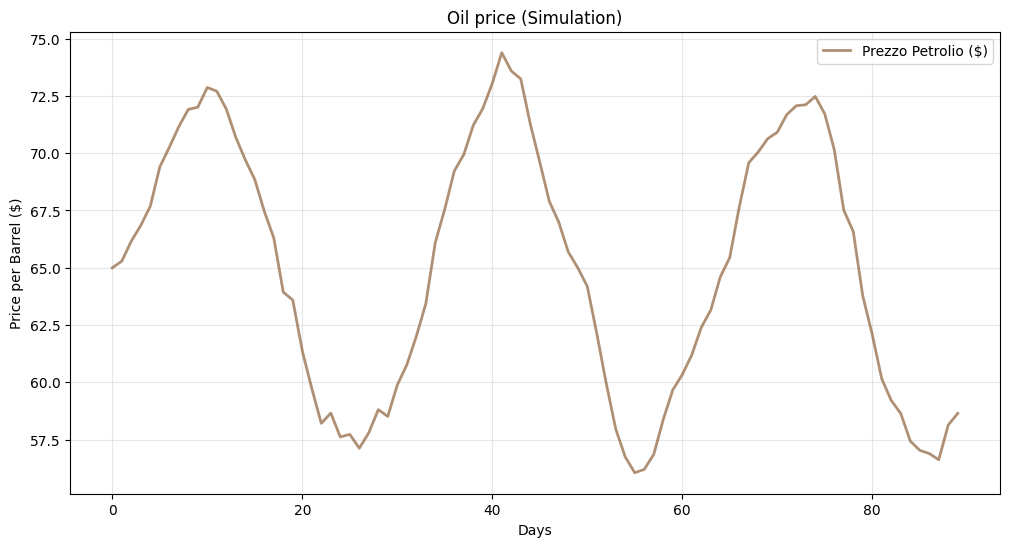

In [ ]:
# Extracting the price of oil
prices = [day['Price'] for day in oil_price_history]
days = range(len(prices))

plt.figure(figsize=(12, 6))
plt.plot(days, prices, label='Prezzo Petrolio ($)', color='#8f6139', alpha=0.7, linewidth=2)

plt.grid(True, alpha=0.3)
plt.title('Oil price (Simulation)')
plt.xlabel('Days')
plt.ylabel('Price per Barrel ($)')
plt.legend()
plt.show()

Example of prices after the simulation for some stations.

In [71]:
print("Simulation completed. Sample of simulated prices for the first 10 stations:")
for i, (station, prices) in enumerate(stations_history.items()):
    if i >= 10:
        break
    print(f"Station {station}: {prices}")

Simulation completed. Sample of simulated prices for the first 10 stations:
Station 29869: [1.609, 1.609, 1.609, 1.609, 1.619, 1.629, 1.639, 1.649, 1.659, 1.669, 1.679, 1.689, 1.689, 1.689, 1.689, 1.689, 1.689, 1.689, 1.689, 1.689, 1.679, 1.679, 1.679, 1.669, 1.659, 1.649, 1.649, 1.639, 1.629, 1.629, 1.639, 1.649, 1.649, 1.659, 1.669, 1.679, 1.689, 1.709, 1.719, 1.729, 1.739, 1.749, 1.759, 1.769, 1.769, 1.769, 1.769, 1.769, 1.769, 1.769, 1.769, 1.759, 1.749, 1.739, 1.729, 1.719, 1.719, 1.719, 1.709, 1.699, 1.709, 1.719, 1.729, 1.739, 1.749, 1.759, 1.769, 1.779, 1.789, 1.799, 1.809, 1.809, 1.809, 1.809, 1.819, 1.819, 1.819, 1.819, 1.819, 1.819, 1.819, 1.819, 1.809, 1.799, 1.779, 1.769, 1.749, 1.739, 1.729, 1.719]
Station 56973: [1.609, 1.609, 1.609, 1.609, 1.619, 1.629, 1.639, 1.649, 1.689, 1.699, 1.709, 1.719, 1.739, 1.739, 1.779, 1.779, 1.779, 1.779, 1.809, 1.809, 1.819, 1.809, 1.829, 1.799, 1.759, 1.739, 1.689, 1.679, 1.639, 1.639, 1.619, 1.649, 1.629, 1.649, 1.579, 1.659, 1.699, 1.7

In [76]:
import plotly.graph_objects as go

# Inizializza la figura
fig = go.Figure()

# Trace for the frist 10 stations to avoid overcrowding the graph, but you can adjust this number as needed.
for i, (station, prices) in enumerate(stations_history.items()):
    if i >= 10:
        break
        
    fig.add_trace(go.Scatter(
        y=prices,  
        mode='lines',  # 'lines+markers' for few days, 'lines' for many days
        name=f"Station {station}",
        line=dict(width=2)
    ))

# Miglioriamo l'estetica e la leggibilità
fig.update_layout(
    title='<b>Temporal evolution of simulated price</b><br><sup>10 different network stations</sup>',
    xaxis_title='Time (Days / Simulation step)',
    yaxis_title='Gasoline price (€/L)',
    template='plotly_white',
    hovermode='x unified', # Fondamentale: passando col mouse vedi tutti i prezzi di quel giorno assieme!
    legend=dict(title='Stations')
)

# Mostra il grafico
fig.show()

While this simulator serves as a proof of concept, it remains a fundamental model that requires further calibration. 
Future iterations should involve refining the underlying code and incorporating higher order variables to increase precision. It is important to note that because retail pricing is intrinsically linked to the inherent volatility of global crude oil markets, achieving a perfect real world replication is constrained by external macroeconomic factors that cannot be fully captured in a closed-loop simulation.

# 9 Future developments

Turning back of what we have done at the start, the temporal network, where edges represent identical daily pricing between stations, reveals a striking phenomenon: over 160 pairs of stations maintained absolute price synchronization across the entire 91 day observation period. This persistent correlation warrants further investigation to determine whether it stems from shared ownership, automated pricing algorithms, or localized tacit collusion.

In [72]:
index = 0
for edge in lombardia_gasoline.edges:
    
    if len(edge.history()) == 91:
        index += 1

print(index)

165


In [73]:
index = 0
for edge in lombardia_diesel.edges:
    
    if len(edge.history()) == 91:
        index += 1

print(index)

164
